# APS360 Project - X-ray Diagnosis on Bacterial and Viral Pneumonia

Collaborators:

Weixuan Sun  1003803048 

Jiawen Li    1002904253

Qiaoyi Yan   1003130774 

Yiran Qiu    1004172290

In [ ]:
#save model
NP_model = NP_xray_CNN()
training...
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 32, 0.0001, 10, "Winston") # e.g.
torch.save(NP_model.state_dict(), file_name)

#load model
NP_model = NP_xray_CNN()
NP_model.load_state_dict(torch.load(file_name))

## Colab Link

Colab Link: https://colab.research.google.com/drive/1k8NYtR_vONczE_S6njCgt6RGb_SrJkVc?usp=sharing

## Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchsummary import summary

import random
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import shutil
from PIL import Image

torch.manual_seed(6)

In [ ]:
#install the older version of torch and torchvision that will work the the code in this project
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 1. Data Preporcessing

We will be using x-ray images available at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

### a) Creating folder structure

This code will split the pneumonia image folder into 2 subfolders, virus or bacteria, based on the filename.

In [ ]:
# DO NOT run this code

src = '/content/gdrive/My Drive/APS 360 Project/dataset/PNEUMONIA'
dst_virus = '/content/gdrive/My Drive/APS 360 Project/dataset/virus'
dst_bacteria = '/content/gdrive/My Drive/APS 360 Project/dataset/bacteria'

for (root,dirs,files) in os.walk(src): 
  for file in files:
    #print(file)
    words = file.split('_')
    if 'virus' in words:      
      if not os.path.isdir(dst_virus):
        os.mkdir(dst_virus)
      shutil.copy(src + '/' + file, dst_virus)
    elif 'bacteria' in words:      
      if not os.path.isdir(dst_bacteria):
        os.mkdir(dst_bacteria)
      shutil.copy(src + '/' + file, dst_bacteria)
    else:
      print("Not valid filename:", file)
  break


### b) Data Splitting and Data Loading

training set: 70%

validation set: 15%

testing set: 15%

Data are being loaded to accommodate different approaches to the problem, either a multiclass (3 classes) classification or two binary classifications (Normal vs Pneumonia and Bacteria vs Virus).

In [ ]:
# DO NOT run this code
t = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

bs = 16

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'
Normal_vs_Pneumonia_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Normal_vs_Pneumonia_dataset'
Bacteria_vs_Virus_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Bacteria_vs_Virus_dataset'


data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

multiclass_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
multiclass_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
multiclass_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For multiclass classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(multiclass_train_loader.dataset))
print("validation example number: ", len(multiclass_val_loader.dataset))
print("test example number: ", len(multiclass_test_loader.dataset))
print()


data = torchvision.datasets.ImageFolder(root=Normal_vs_Pneumonia_dataset_Path, transform=t)
NP_classes = ['NORMAL', 'PNEUMONIA']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

NP_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
NP_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
NP_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For Normal_vs_Pneumonia binary classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(NP_train_loader.dataset))
print("validation example number: ", len(NP_val_loader.dataset))
print("test example number: ", len(NP_test_loader.dataset))
print()

data = torchvision.datasets.ImageFolder(root=Bacteria_vs_Virus_dataset_Path, transform=t)
BV_classes = ['bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

BV_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
BV_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
BV_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For Bacteria_vs_Virus binary classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(BV_train_loader.dataset))
print("validation example number: ", len(BV_val_loader.dataset))
print("test example number: ", len(BV_test_loader.dataset))
print()


For multiclass classification: 
labels: {'NORMAL': 0, 'bacteria': 1, 'virus': 2}
training example number:  4062
validation example number:  870
test example number:  872

For Normal_vs_Pneumonia binary classification: 
labels: {'NORMAL': 0, 'PNEUMONIA': 1}
training example number:  4099
validation example number:  878
test example number:  879

For Bacteria_vs_Virus binary classification: 
labels: {'bacteria': 0, 'virus': 1}
training example number:  2954
validation example number:  633
test example number:  634



### c) Save and Load Datasets

In [ ]:
# DO NOT run this code
if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  os.mkdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs))

torch.save(multiclass_train_loader, '../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
torch.save(multiclass_val_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_val_loader.pth'.format(bs))
torch.save(multiclass_test_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_test_loader.pth'.format(bs))
torch.save(NP_train_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_train_loader.pth'.format(bs))
torch.save(NP_val_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_val_loader.pth'.format(bs))
torch.save(NP_test_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_test_loader.pth'.format(bs))
torch.save(BV_train_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_train_loader.pth'.format(bs))
torch.save(BV_val_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_val_loader.pth'.format(bs))
torch.save(BV_test_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_test_loader.pth'.format(bs))

In [ ]:
# Run this cell only to load all dataloaders

bs = 64 # select batch size
num_workers = 1

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  print("Cannot load. This batch size dataloader has not been created yet.")
else:
  multiclass_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
  multiclass_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_val_loader.pth'.format(bs))
  multiclass_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_test_loader.pth'.format(bs))
  NP_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_train_loader.pth'.format(bs))
  NP_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_val_loader.pth'.format(bs))
  NP_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_test_loader.pth'.format(bs))
  BV_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_train_loader.pth'.format(bs))
  BV_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_val_loader.pth'.format(bs))
  BV_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_test_loader.pth'.format(bs))

Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

In [ ]:
for img, labels in iter(BV_test_loader):
  print(1)
  break;

1


### d) Verification on Dataset
We print the images to verify the data and labels before sending into the neural network.

NORMAL


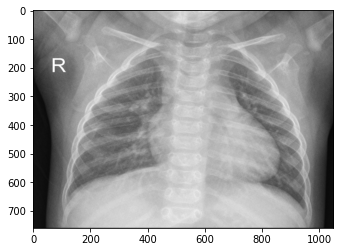

In [ ]:
# Verification on Multiclass dataset  
images, labels = iter(multiclass_train_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display

print(Multiclass_classes[labels[0]])
plt.title = Multiclass_classes[labels[0]]
fig = plt.imshow(images[0], cmap='gray')

NORMAL


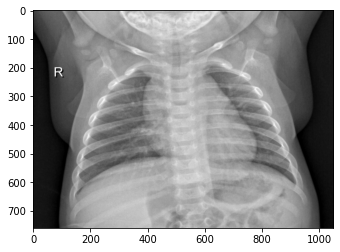

In [ ]:
print(Multiclass_classes[labels[1]])
plt.title = Multiclass_classes[labels[1]]
fig = plt.imshow(images[1], cmap='gray')

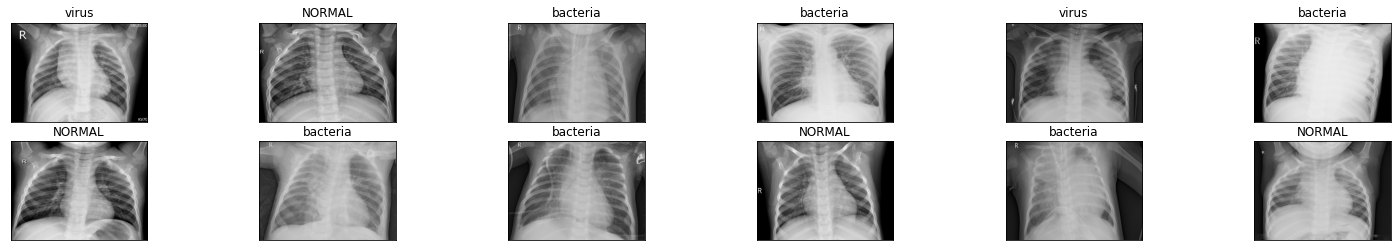

In [ ]:
# Verification on Multiclass dataset  
images, labels = iter(multiclass_train_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display

# plot 12 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(26, 4))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    ax.set_title(Multiclass_classes[labels[idx]])

In [ ]:
print(images[idx].max())
print(images[idx].min())

1.0
0.0


<class 'torch.Tensor'>


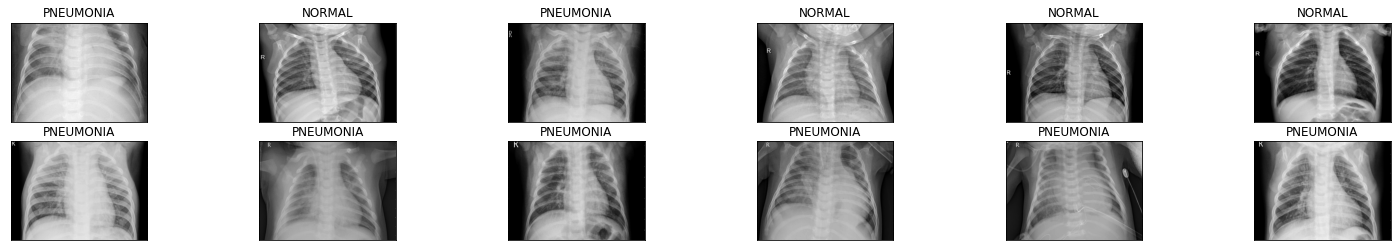

In [ ]:
# Verification on Multiclass dataset  
images, labels = iter(NP_train_loader).next() # obtain one batch of images
print(type(images))
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display

# plot 12 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(26, 4))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    ax.set_title(NP_classes[labels[idx]])

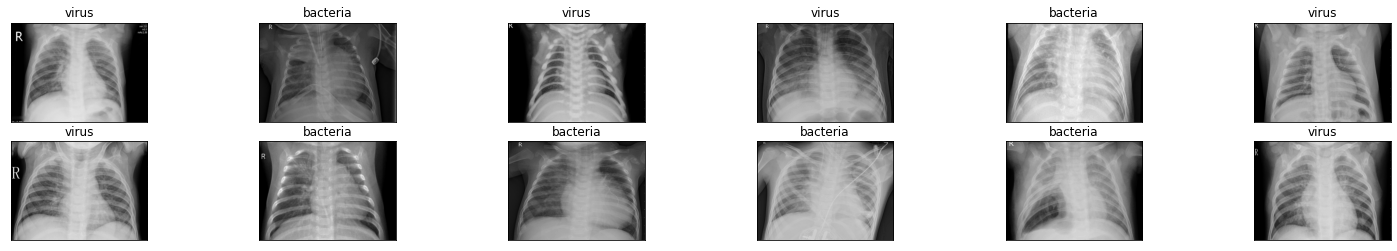

In [ ]:
# Verification on Multiclass dataset  
images, labels = iter(BV_train_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display

# plot 12 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(26, 4))
for idx in np.arange(12):
    ax = fig.add_subplot(2, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    ax.set_title(BV_classes[labels[idx]])

In [ ]:
images, labels = iter(NP_train_loader).next()
print(images.size())

torch.Size([32, 1, 760, 1050])


In [ ]:
print(len(labels))

32


## 2. SVM Baseline Model


#####a) Reduce the size images to feed into SVM

In [ ]:
t = transforms.Compose(
        [transforms.Resize((224, 224)), #reduce the size of images otherwise RAM crashes
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'

data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
data_loader = torch.utils.data.DataLoader(data, batch_size=int(len(data.imgs)/1), shuffle=True)
imgs, labels = iter(data_loader).next()

In [ ]:
t = transforms.Compose(
        [transforms.Resize((224, 224)), #reduce the size of images otherwise RAM crashes
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'

data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
data_loader = torch.utils.data.DataLoader(data, batch_size=int(len(data.imgs)/1), shuffle=True)
imgs, labels = iter(data_loader).next()

#####b) Build and test the baseline model

In [ ]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, labels)
X_train = np.reshape(X_train.squeeze(1), (X_train.shape[0], 1, -1)).squeeze(1)
X_test = np.reshape(X_test.squeeze(1), (X_test.shape[0], 1, -1)).squeeze(1)
print('Training data and label sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Testing data and label sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:
# build SVM model
classifier = svm.SVC(gamma=0.001)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("SVC model: ", classifier)

print("\n                  Classification report:\n", metrics.classification_report(y_test, y_pred))

In [ ]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, labels)
X_train = np.reshape(X_train.squeeze(1), (X_train.shape[0], 1, -1)).squeeze(1)
X_test = np.reshape(X_test.squeeze(1), (X_test.shape[0], 1, -1)).squeeze(1)
print('Training data and label sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Testing data and label sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

# build SVM model
classifier = svm.SVC(gamma=0.001)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
print("SVC model: ", classifier)

print("\n                  Classification report:\n", metrics.classification_report(y_test, y_pred))

Training data and label sizes: 
torch.Size([4353, 50176]), torch.Size([4353])
Testing data and label sizes: 
torch.Size([1451, 50176]), torch.Size([1451])
SVC model:  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

                  Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       387
           1       0.78      0.86      0.82       676
           2       0.67      0.51      0.58       388

    accuracy                           0.78      1451
   macro avg       0.77      0.76      0.76      1451
weighted avg       0.77      0.78      0.77      1451



## 3. Generating new data

### a) Model

In [ ]:
t = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

bs=16
GAN_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/GAN_multiclass_dataset/virus'

data = torchvision.datasets.ImageFolder(root=GAN_dataset_Path, transform=t)
GAN_multiclass_classes = ['virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

GAN_multiclass_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
GAN_multiclass_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
GAN_multiclass_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  os.mkdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs))

torch.save(GAN_multiclass_train_loader, '../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_multiclass_train_loader.pth'.format(bs))
torch.save(GAN_multiclass_val_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_multiclass_val_loader.pth'.format(bs))
torch.save(GAN_multiclass_test_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_multiclass_test_loader.pth'.format(bs))

In [ ]:
#GAN for normal class
t = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

bs=16
GAN_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/GAN_multiclass_dataset/normal'

data = torchvision.datasets.ImageFolder(root=GAN_dataset_Path, transform=t)
GAN_multiclass_classes = ['normal']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

GAN_multiclass_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
GAN_multiclass_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
GAN_multiclass_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  os.mkdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs))

torch.save(GAN_normal_train_loader, '../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_normal_train_loader.pth'.format(bs))
torch.save(GAN_normal_val_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_normal_val_loader.pth'.format(bs))
torch.save(GAN_normal_test_loader, '/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/GAN_normal_test_loader.pth'.format(bs))

NameError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(760*1050, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 760*1050) # flatten image
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 760*1050)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))
        return out

D = Discriminator()
G = Generator()

### b) Training


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data

def train(G, D, lr=0.002, batch_size=64, num_epochs=20):

    rand_size = 100;

    # optimizers for generator and discriminator
    d_optimizer = optim.Adam(D.parameters(), lr)
    g_optimizer = optim.Adam(G.parameters(), lr)
 
    # define loss function
    criterion = nn.BCEWithLogitsLoss()

    # get the training datasets
    #train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

    # prepare data loader
    train_loader = GAN_multiclass_train_loader

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # fixed data for testing
    sample_size=16
    test_noise = np.random.uniform(-1, 1, size=(sample_size, rand_size))
    test_noise = torch.from_numpy(test_noise).float()

    for epoch in range(num_epochs):
        D.train()
        G.train()
        GAN_images = []
        for batch_i, (real_images, _) in enumerate(train_loader):
                    
            batch_size = real_images.size(0)
            
            # rescale images to range -1 to 1
            real_images = real_images*2 - 1
            
            # === Train the Discriminator ===
            
            d_optimizer.zero_grad()

            # discriminator losses on real images 
            D_real = D(real_images)
            labels = torch.ones(batch_size)
            d_real_loss = criterion(D_real.squeeze(), labels)
            
            # discriminator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

            D_fake = D(fake_images)
            labels = torch.zeros(batch_size) # fake labels = 0
            d_fake_loss = criterion(D_fake.squeeze(), labels)
            
            # add up losses and update parameters
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # === Train the Generator ===
            g_optimizer.zero_grad()
            
            # generator losses on fake images
            z = np.random.uniform(-1, 1, size=(batch_size, rand_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
          
            D_fake = D(fake_images)
            labels = torch.ones(batch_size) #flipped labels

            # compute loss and update parameters
            g_loss = criterion(D_fake.squeeze(), labels)
            g_loss.backward()
            g_optimizer.step()

        # print loss
        print('Epoch [%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              % (epoch + 1, num_epochs, d_loss.item(), g_loss.item()))

        # append discriminator loss and generator loss
        losses.append((d_loss.item(), g_loss.item()))
        
        # plot images
        G.eval()
        D.eval()
        test_images = G(test_noise)

        plt.figure(figsize=(9, 3))
        for k in range(16):
            GAN_images
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].data.numpy().reshape(760, 1050), cmap='Greys')
        plt.show()
    
    return losses

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  output += bias


Epoch [1/30], d_loss: 3.2510, g_loss: 6.1072, 


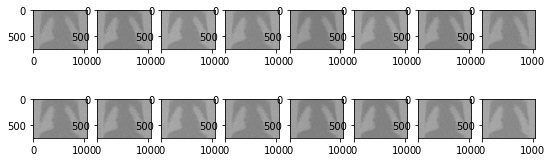

Epoch [2/30], d_loss: 0.1889, g_loss: 19.4118, 


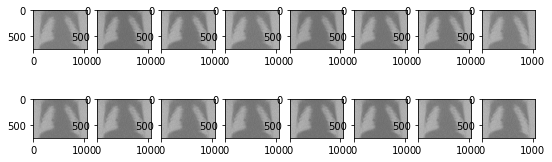

Epoch [3/30], d_loss: 1.4162, g_loss: 28.4760, 


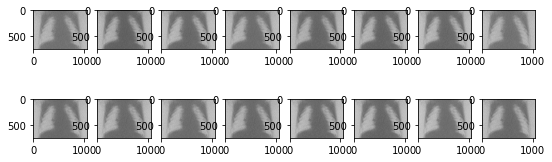

Epoch [4/30], d_loss: 145.6591, g_loss: 15.9592, 


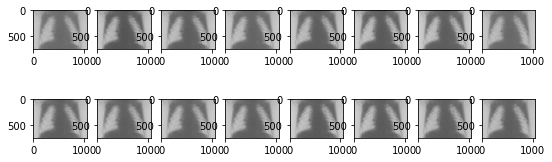

Epoch [5/30], d_loss: 64.0084, g_loss: 0.0000, 


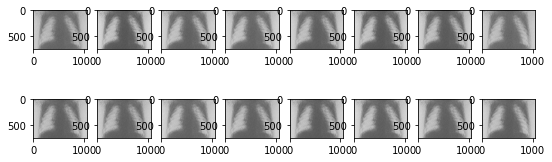

Epoch [6/30], d_loss: 37.1472, g_loss: 0.0883, 


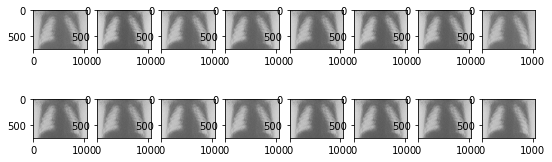

Epoch [7/30], d_loss: 48.7992, g_loss: 10.0453, 


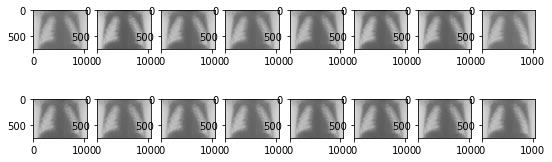

Epoch [8/30], d_loss: 32.7634, g_loss: 15.8325, 


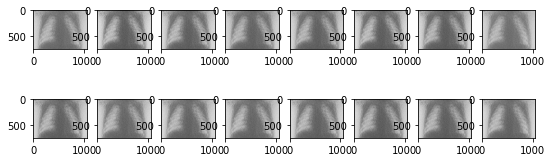

Epoch [9/30], d_loss: 11.6472, g_loss: 20.0296, 


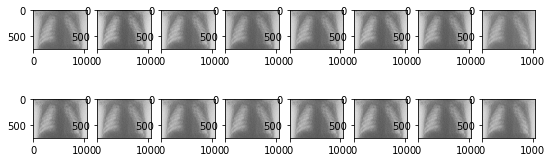

Epoch [10/30], d_loss: 18.7409, g_loss: 21.7853, 


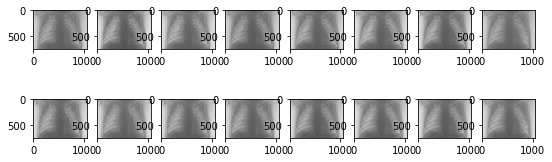

Epoch [11/30], d_loss: 6.6603, g_loss: 22.0394, 


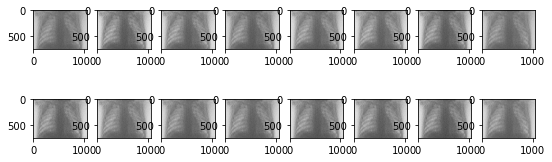

Epoch [12/30], d_loss: 3.3867, g_loss: 7.4375, 


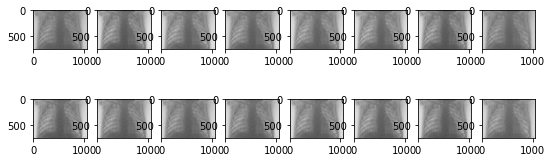

Epoch [13/30], d_loss: 1.5502, g_loss: 10.9298, 


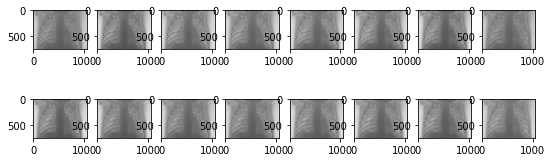

Epoch [14/30], d_loss: 2.8347, g_loss: 3.5526, 


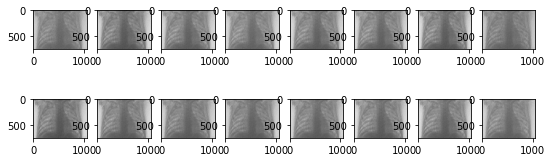

Epoch [15/30], d_loss: 28.2958, g_loss: 0.6162, 


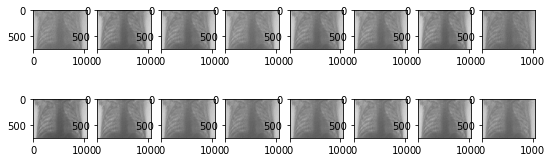

Epoch [16/30], d_loss: 28.9933, g_loss: 2.0220, 


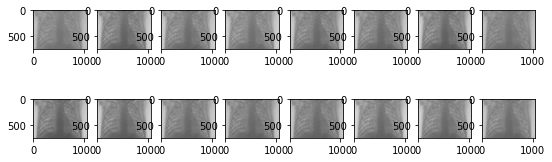

Epoch [17/30], d_loss: 39.6964, g_loss: 3.9762, 


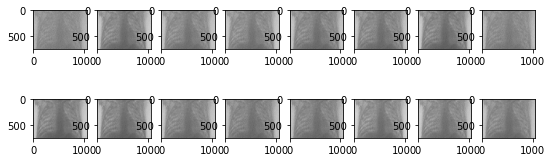

Epoch [18/30], d_loss: 12.7268, g_loss: 12.5733, 


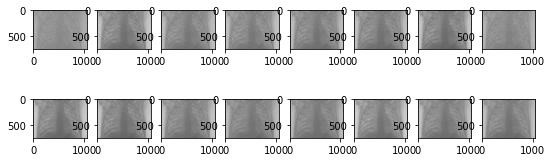

Epoch [19/30], d_loss: 10.2274, g_loss: 25.7870, 


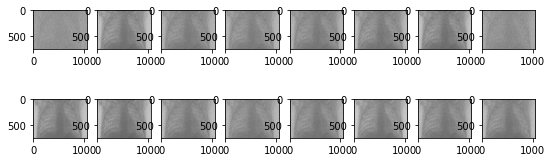

Epoch [20/30], d_loss: 1.0882, g_loss: 20.7318, 


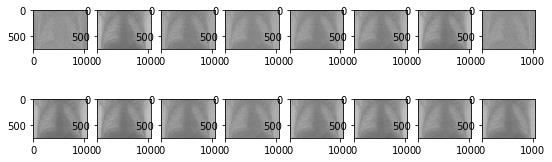

Epoch [21/30], d_loss: 2.4510, g_loss: 17.3317, 


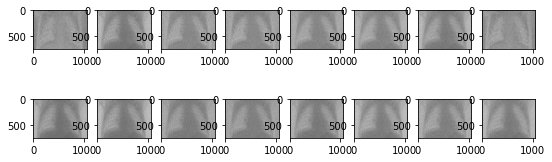

Epoch [22/30], d_loss: 7.7747, g_loss: 7.6800, 


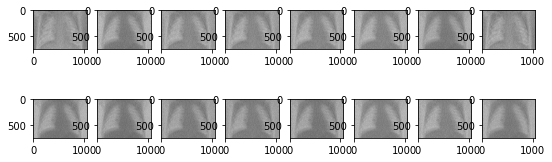

Epoch [23/30], d_loss: 9.5611, g_loss: 9.0987, 


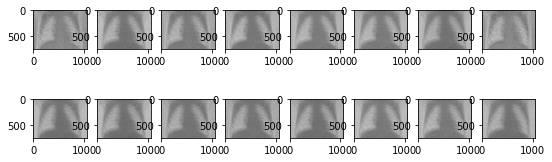

Epoch [24/30], d_loss: 17.2077, g_loss: 15.1384, 


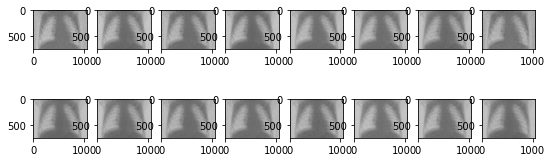

Epoch [25/30], d_loss: 10.1683, g_loss: 4.5616, 


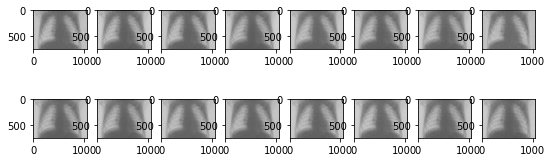

Epoch [26/30], d_loss: 4.6622, g_loss: 31.8972, 


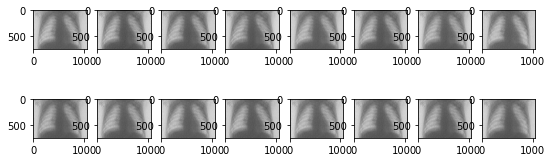

Epoch [27/30], d_loss: 7.4965, g_loss: 24.0580, 


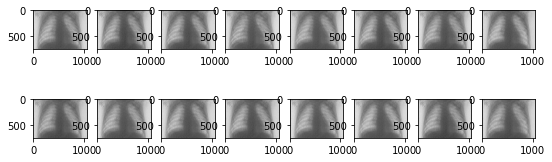

Epoch [28/30], d_loss: 6.3199, g_loss: 1.4240, 


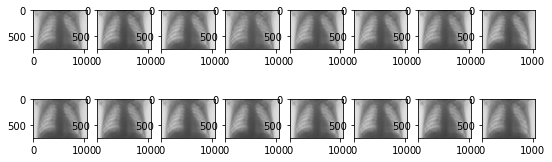

Epoch [29/30], d_loss: 31.5857, g_loss: 0.3208, 


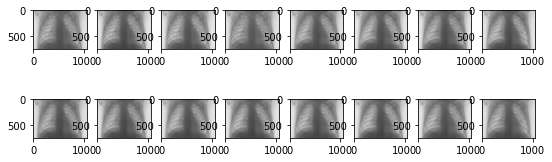

Epoch [30/30], d_loss: 29.9480, g_loss: 0.0000, 


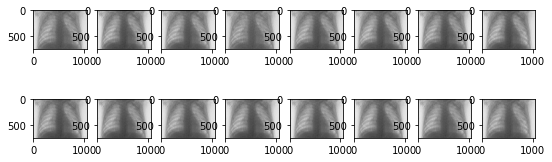

In [ ]:
losses = train(G, D, lr=0.002, batch_size=64, num_epochs=30)

file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("GAN_virus", 64, 0.002, 30,  "Erica")
torch.save(G.state_dict(), file_name)

In [ ]:
GAN_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("GAN", 64, 0.002, 30,  "Crystal")
GAN_model.load_state_dict(torch.load(GAN_file_name))

NameError: ignored

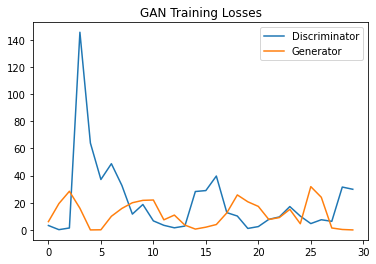

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("GAN Training Losses")
plt.legend()

### c) Visualize and Save Generated Data

Using GPU ...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  output += bias


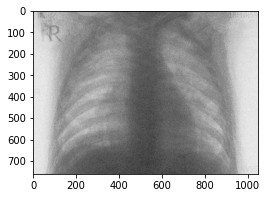

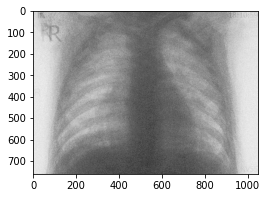

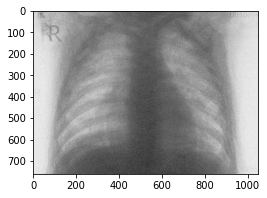

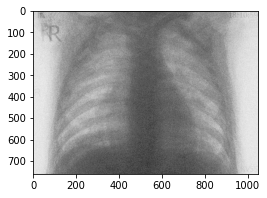

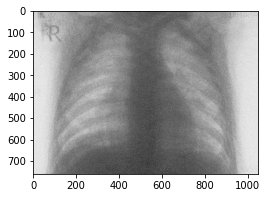

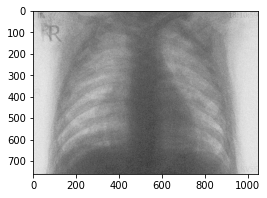

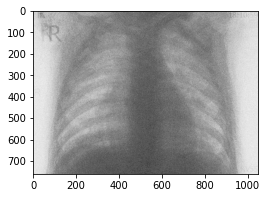

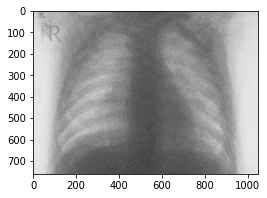

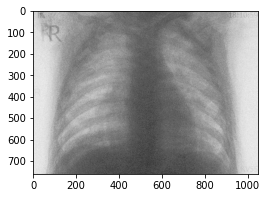

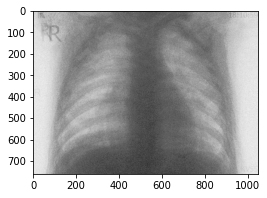

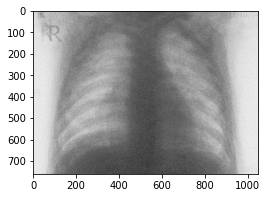

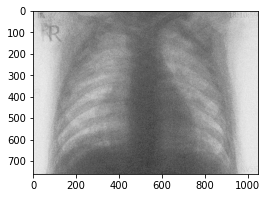

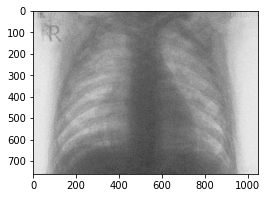

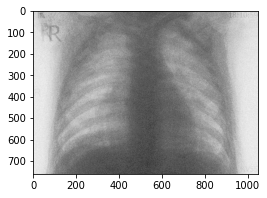

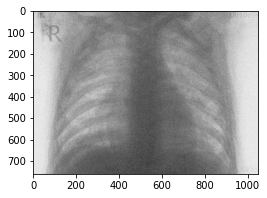

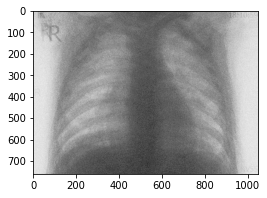

In [ ]:
bs=16
unsorted_datapath = '/content/gdrive/My Drive/APS 360 Project/GAN_dataset/Raw_data//'
normal_datapath = '/content/gdrive/My Drive/APS 360 Project/GAN_dataset/Raw_data/NORMAL/'
virus_datapath = '/content/gdrive/My Drive/APS 360 Project/GAN_dataset/Raw_data/pneumonia/virus/'
bacteria_datapath = '/content/gdrive/My Drive/APS 360 Project/GAN_dataset/Raw_data/pneumonia/bacteria/'
pneumonia_datapath = '/content/gdrive/My Drive/APS 360 Project/GAN_dataset/Raw_data/PNEUMONIA/'
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("GAN_virus", 64, 0.002, 30,  "Erica")
torch.save(G.state_dict(), file_name)
G.load_state_dict(torch.load(file_name))

use_cuda = True
count = 0 

if use_cuda and torch.cuda.is_available():
  G.cuda()
  print("Using GPU ...")

sample_size=16
rand_size=100
test_noise = np.random.uniform(-1, 1, size=(sample_size, rand_size))
test_noise = torch.from_numpy(test_noise).float()

for imgs in iter(test_noise): 
  #print(imgs.squeeze(1)[0].size())

  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()

  recons = G(imgs)
  recon = recons.squeeze(-1).detach().cpu().numpy().reshape(760, 1050)
  plt.figure(figsize=(9, 3))
  plt.imshow(recon, cmap='Greys')
  plt.show()

## 3. Autoencoder

### a) Model

In [ ]:
class Autoencoder_simplify_1(nn.Module): #too simple
    def __init__(self):
        super(Autoencoder_simplify_1, self).__init__()
        self.encoder = nn.Sequential( 
            #kernal size 30, calculate output padding number, reduce layers, half
            nn.Conv2d(1, 10, 20, stride=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 1, 20, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [ ]:
class Autoencoder_simplify_2(nn.Module):
    def __init__(self):
        super(Autoencoder_simplify_2, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Linear(1050*760, 700000),
        )
        self.decoder = nn.Sequential(
            nn.Linear(700000, 1050*760),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [ ]:
class Autoencoder_test(nn.Module):
    def __init__(self):
        super(Autoencoder_test, self).__init__()
        self.encoder = nn.Sequential( 
            #kernal size 30, calculate output padding number, reduce layers, half
            nn.Conv2d(1, 10, 20, stride=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), #kernel_size, stride
            nn.Conv2d(10, 20, 20, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            #nn.Conv2d(32, 64, 30)
        )
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(64, 32, 30),
            #nn.ReLU(),
            #nn.MaxUnpool2d(2,2),
            nn.ConvTranspose2d(20, 10, 20, stride=1),
            nn.ReLU(),
            #nn.MaxUnpool2d(2,2),
            nn.ConvTranspose2d(10, 1, 20, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [ ]:
class Autoencoder_alternative(nn.Module):
    def __init__(self):
        super(Autoencoder_alternative, self).__init__()
        self.encoder = nn.Sequential( 
            #kernal size 30, calculate output padding number, reduce layers, half
            nn.Conv2d(1, 16, 5, stride=1),
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), #kernel_size, stride
            nn.Conv2d(16, 32, 5, stride=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2),
            #nn.Conv2d(32, 64, 30)
        )
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(64, 32, 30),
            #nn.ReLU(),
            #nn.MaxUnpool2d(2,2),
            nn.ConvTranspose2d(32, 16, 5, stride=1),
            nn.ReLU(),
            #nn.MaxUnpool2d(2,2),
            nn.ConvTranspose2d(16, 1, 5, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [ ]:
bs=16

multiclass_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
#multiclass_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_val_loader.pth'.format(bs))
#multiclass_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_test_loader.pth'.format(bs))

In [ ]:
#NP_autoencoder = Autoencoder_test()
autoencoder = Autoencoder_simplify_1()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  autoencoder = nn.DataParallel(autoencoder)

autoencoder.to(device)
#autoencoder = torch.nn.DataParallel(module=autoencoder, device_ids=range(torch.cuda.device_count()))


use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoencoder.cuda()
  !nvidia-smi
  print("Using GPU ...")

summary(autoencoder, input_size=(1, 760, 1050))


Wed Jul 29 20:00:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W /  70W |    791MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### b) Training

In [ ]:
def auto_train(model, train_loader, num_epochs, batch_size=16, learning_rate=0.0001):
    torch.manual_seed(6)
    criterion = nn.MSELoss() # mean square error loss 
    
    #binary cross entropy loss 
    
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate) # <--
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


    outputs = []
    for epoch in range(num_epochs):
        train_loss = 0
        n = 0
        for data in train_loader:
          n = n + 1
          imgs, _ = data

          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
          recon = model(imgs)
          loss = criterion(recon, imgs)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          train_loss = train_loss + float(loss)

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(train_loss / n)))
        outputs.append((epoch, imgs, recon),)
    return outputs

### c) Testing

In [ ]:
outputs = auto_train(autoencoder, multiclass_train_loader, num_epochs=5)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("autoencoder", 16, 0.0001, 5, "Winston")
torch.save(autoencoder.state_dict(), file_name)

Epoch:1, Loss:0.0323
Epoch:2, Loss:0.0054
Epoch:3, Loss:0.0040
Epoch:4, Loss:0.0039
Epoch:5, Loss:0.0037


In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    1652 KB |  588045 KB |    1165 MB |    1164 MB |\n|       from large pool |       0 KB |  586393 KB |    1162 MB |    1162 MB |\n|       from small pool |    1652 KB |    1652 KB |       3 MB |       1 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    1652 KB |  588045 KB |    1165 MB |    1164 MB |\n|       from large pool |       0 KB |  586393 KB |

### d) Save New Data after Autoencoder Stage

In [ ]:
t = transforms.Compose(
        [transforms.Resize((152, 210)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

bs = 16

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'


data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
#train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

multiclass_loader = torch.utils.data.DataLoader(data, batch_size=bs, shuffle=True)
#multiclass_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
#multiclass_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

In [ ]:
use_cuda = True
autoencoder = Autoencoder_simplify_1()
if use_cuda and torch.cuda.is_available():
  autoencoder.cuda()
outputs = auto_train(autoencoder, multiclass_loader, num_epochs=5)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("autoencoder_alternative", 16, 0.0001, 5, "Winston")
torch.save(autoencoder.state_dict(), file_name)

Epoch:1, Loss:0.0274
Epoch:2, Loss:0.0118
Epoch:3, Loss:0.0102
Epoch:4, Loss:0.0094
Epoch:5, Loss:0.0089


Using GPU ...
[[0.49709687 0.4946825  0.48956546 ... 0.5017075  0.50114405 0.50034606]
 [0.4981788  0.49814403 0.4898069  ... 0.51060873 0.5127994  0.5059579 ]
 [0.4913458  0.4924012  0.48009688 ... 0.5060442  0.50819117 0.5056485 ]
 ...
 [0.4915754  0.48817593 0.48350006 ... 0.484724   0.4897153  0.49471495]
 [0.496345   0.49240237 0.48915038 ... 0.48862344 0.49415934 0.49672633]
 [0.49823308 0.49772018 0.49624506 ... 0.4978624  0.49965715 0.49959245]]


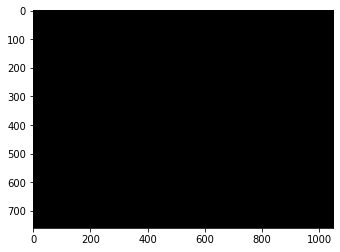

In [ ]:
# testing (ignore)
bs=32
multiclass_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
normal_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/NORMAL'
virus_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/pneumonia/virus'
bacteria_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/pneumonia/bacteria'
pneumonia_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/pneumonia'
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("autoencoder", 16, 0.0001, 5, "Winston")
autoencoder = Autoencoder_simplify_1()
autoencoder.load_state_dict(torch.load(file_name))

use_cuda = True

if use_cuda and torch.cuda.is_available():
  autoencoder.cuda()
  print("Using GPU ...")

for imgs, labels in iter(multiclass_train_loader): 
  #print(imgs.squeeze(1)[0].size())

  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()

  recons = autoencoder(imgs)

  for i in range(len(labels)): 
    recon = recons.squeeze(1)[i].detach().cpu().numpy()
    #recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    img = Image.fromarray(recon)
    print(recons.squeeze(1)[i].detach().cpu().numpy())
    plt.imshow(img)
    break
    if labels[i] == 0:
      normal_datapath
  break
    

In [ ]:
img = imgs.squeeze(1)[i].detach().cpu().numpy()
print("autoencoder input: ", img, "\nimage size:", img.shape)
print("autoencoder output: ", recon, "\nimage size:", recon.shape)

autoencoder input:  [[0.1882353  0.6        0.6039216  ... 0.5137255  0.5058824  0.5176471 ]
 [0.18039216 0.5803922  0.5921569  ... 0.5176471  0.5019608  0.52156866]
 [0.18431373 0.57254905 0.5568628  ... 0.5254902  0.5137255  0.52156866]
 ...
 [0.         0.         0.         ... 0.03529412 0.01960784 0.01176471]
 [0.         0.         0.         ... 0.04313726 0.01960784 0.01176471]
 [0.         0.         0.         ... 0.05490196 0.02745098 0.01176471]] 
image size: (760, 1050)
autoencoder output:  [[0.49709687 0.4946825  0.48956546 ... 0.5017075  0.50114405 0.50034606]
 [0.4981788  0.49814403 0.4898069  ... 0.51060873 0.5127994  0.5059579 ]
 [0.4913458  0.4924012  0.48009688 ... 0.5060442  0.50819117 0.5056485 ]
 ...
 [0.4915754  0.48817593 0.48350006 ... 0.484724   0.4897153  0.49471495]
 [0.496345   0.49240237 0.48915038 ... 0.48862344 0.49415934 0.49672633]
 [0.49823308 0.49772018 0.49624506 ... 0.4978624  0.49965715 0.49959245]] 
image size: (760, 1050)


In [ ]:
print(img[500])
print(recon[500])

[0. 0. 0. ... 0. 0. 0.]
[0.45819393 0.4210589  0.3957686  ... 0.396748   0.43493146 0.465818  ]


798000


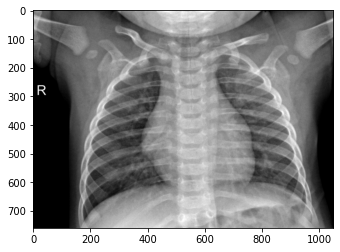

In [ ]:
plt.imshow(img, cmap="gray")
print(img.size)

(1050, 760)


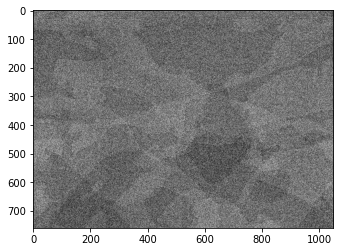

In [ ]:
# image after recon
test = Image.fromarray(recons.squeeze(1)[i].detach().cpu().numpy(), mode='L')
plt.imshow(test, cmap="gray")
print(test.size)

In [ ]:
labels[0].item()

0

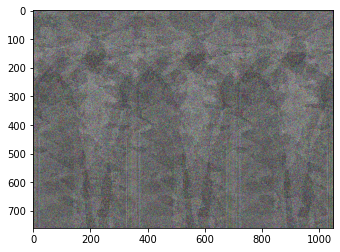

In [ ]:
test = Image.fromarray(recon, mode='RGB')
plt.imshow(test)

In [ ]:
# Start here
bs=16
multiclass_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
normal_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/NORMAL/'
virus_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/pneumonia/virus/'
bacteria_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/pneumonia/bacteria/'
pneumonia_datapath = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Raw_data/PNEUMONIA/'
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("autoencoder", 16, 0.0001, 5, "Winston")
autoencoder = Autoencoder_simplify_1()
autoencoder.load_state_dict(torch.load(file_name))

use_cuda = True
count = 0 

if use_cuda and torch.cuda.is_available():
  autoencoder.cuda()
  print("Using GPU ...")

for imgs, labels in iter(multiclass_train_loader): 
  #print(imgs.squeeze(1)[0].size())

  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()

  recons = autoencoder(imgs)

  for i in range(len(labels)): 
    recon = recons.squeeze(1)[i].detach().cpu().numpy()
    #recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    img = Image.fromarray(recon)
    img = img.convert("L")

    if use_cuda and torch.cuda.is_available():
      label = labels[i].item()
    else:
      label = labels[i]
      
    if label == 0:
      img.save(normal_datapath + str(count) + 'n.jpg')
    elif label == 1:
      img.save(bacteria_datapath + str(count) + 'b.jpg')
      img.save(pneumonia_datapath + str(count) + 'bp.jpg')
    elif label == 2:
      img.save(virus_datapath + str(count) + 'v.jpg')
      img.save(pneumonia_datapath + str(count) + 'vp.jpg')

    count += 1

Using GPU ...


In [ ]:
t = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

bs = 16

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Multiclass_dataset'
Normal_vs_Pneumonia_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Normal_vs_Pneumonia_dataset'
Bacteria_vs_Virus_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataset/Bacteria_vs_Virus_dataset'


data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

multiclass_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
multiclass_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
multiclass_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For multiclass classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(multiclass_train_loader.dataset))
print("validation example number: ", len(multiclass_val_loader.dataset))
print("test example number: ", len(multiclass_test_loader.dataset))
print()


data = torchvision.datasets.ImageFolder(root=Normal_vs_Pneumonia_dataset_Path, transform=t)
NP_classes = ['NORMAL', 'PNEUMONIA']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

NP_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
NP_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
NP_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For Normal_vs_Pneumonia binary classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(NP_train_loader.dataset))
print("validation example number: ", len(NP_val_loader.dataset))
print("test example number: ", len(NP_test_loader.dataset))
print()

data = torchvision.datasets.ImageFolder(root=Bacteria_vs_Virus_dataset_Path, transform=t)
BV_classes = ['bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

BV_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
BV_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
BV_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For Bacteria_vs_Virus binary classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(BV_train_loader.dataset))
print("validation example number: ", len(BV_val_loader.dataset))
print("test example number: ", len(BV_test_loader.dataset))
print()

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}'.format(bs)):
  os.mkdir('../content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}'.format(bs))

torch.save(multiclass_train_loader, '../content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
torch.save(multiclass_val_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_val_loader.pth'.format(bs))
torch.save(multiclass_test_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_test_loader.pth'.format(bs))
torch.save(NP_train_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_train_loader.pth'.format(bs))
torch.save(NP_val_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_val_loader.pth'.format(bs))
torch.save(NP_test_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_test_loader.pth'.format(bs))
torch.save(BV_train_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_train_loader.pth'.format(bs))
torch.save(BV_val_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_val_loader.pth'.format(bs))
torch.save(BV_test_loader, '/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_test_loader.pth'.format(bs))

RuntimeError: ignored

In [ ]:
# load autoencoder dataloaders
bs = 32 # select batch size

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  print("Cannot load. This batch size dataloader has not been created yet.")
else:
  multiclass_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_train_loader.pth'.format(bs))
  multiclass_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_val_loader.pth'.format(bs))
  multiclass_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/multiclass_test_loader.pth'.format(bs))
  NP_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_train_loader.pth'.format(bs))
  NP_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_val_loader.pth'.format(bs))
  NP_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/NP_test_loader.pth'.format(bs))
  BV_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_train_loader.pth'.format(bs))
  BV_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_val_loader.pth'.format(bs))
  BV_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/autoencoder_dataloader_bs{0}/BV_test_loader.pth'.format(bs))

Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

## 4. Model Building


### a) CNN model 

We will train two convolutional neural networks to classify the chest x-ray images. Each model is a binary classifier. The first CNN classifies the images into normal or pneumonia categories, then we feed the pneumonia x-ray images to the second CNN model to further divide the images into the bacterial or viral infection. 

In [ ]:
#Normal vs Pneumonia binary classifier - best model
class NP_xray_CNN_1(nn.Module):
    def __init__(self):
        super(NP_xray_CNN_1, self).__init__()
        self.name = "NP_xray_CNN_1"
        self.conv1 = nn.Conv2d(1, 10, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(10, 20, 50, stride=3)
        self.fc1 = nn.Linear(11*20*20, 600)
        self.fc2 = nn.Linear(600, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*20)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

In [ ]:
#Convolutional Neural Network Architecture
#760 x 1050 image input

#Normal vs Pneumonia binary classifier
class NP_xray_CNN(nn.Module):
    def __init__(self):
        super(NP_xray_CNN, self).__init__()
        self.name = "NP_xray_CNN"
        self.conv1 = nn.Conv2d(1, 5, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 50, stride=3)
        self.fc1 = nn.Linear(11*20*10, 100)
        self.fc2 = nn.Linear(100, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*10)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

# Bacteria vs Virus binary classifier
class BV_xray_CNN(nn.Module):
    def __init__(self):
        super(BV_xray_CNN, self).__init__()
        self.name = "BV_xray_CNN"
        self.conv1 = nn.Conv2d(1, 5, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 50, stride=3)
        self.fc1 = nn.Linear(11*20*10, 100)
        self.fc2 = nn.Linear(100, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*10)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

In [ ]:
# Bacteria vs Virus binary classifier - best model
class BV_xray_CNN_2(nn.Module):
    def __init__(self):
        super(BV_xray_CNN_2, self).__init__()
        self.name = "BV_xray_CNN_2"
        self.conv1 = nn.Conv2d(1, 8, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(8, 15, 50, stride=3)
        self.fc1 = nn.Linear(11*20*15, 600)
        self.fc2 = nn.Linear(600, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*15)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

In [ ]:
use_cuda = True
NP_model = NP_xray_CNN_1()
BV_model = BV_xray_CNN_2()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
  BV_model.cuda()

  print('CUDA is available! Training on GPU ...')
  #!nvidia-smi
else:
  print('CUDA is not available. Training on CPU ...')

print("NP model:")
summary(NP_model, input_size=(1, 760, 1050))
print()
print("BV model:")
summary(BV_model, input_size=(1, 760, 1050))

CUDA is available! Training on GPU ...
NP model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1         [-1, 1, 760, 1050]               0
            Conv2d-2         [-1, 10, 237, 334]          25,010
         MaxPool2d-3         [-1, 10, 118, 167]               0
           Dropout-4         [-1, 10, 118, 167]               0
            Conv2d-5           [-1, 20, 23, 40]         500,020
         MaxPool2d-6           [-1, 20, 11, 20]               0
           Dropout-7                 [-1, 4400]               0
            Linear-8                  [-1, 600]       2,640,600
           Dropout-9                  [-1, 600]               0
           Linear-10                    [-1, 2]           1,202
Total params: 3,166,832
Trainable params: 3,166,832
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.04
Forward/backward pa

In [ ]:
use_cuda = True
NP_model = NP_xray_CNN()
BV_model = BV_xray_CNN()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
  BV_model.cuda()

  print('CUDA is available! Training on GPU ...')
  !nvidia-smi
else:
  print('CUDA is not available. Training on CPU ...')

summary(NP_model, input_size=(1, 760, 1050))

CUDA is available! Training on GPU ...
Mon Jul 27 02:52:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    58W / 149W |    899MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                 

### b) Transfer Learning


In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
#vgg =  torchvision.models.vgg16(pretrained=True)#the team choose to use alexnet for training 

In [ ]:
!pip install googlenet_pytorch
!pip3 install resnet_pytorch

In [ ]:
import torch
from googlenet_pytorch import GoogLeNet
from resnet_pytorch import ResNet
googlenet = GoogLeNet.from_pretrained('googlenet')
resnet = ResNet.from_pretrained("resnet18")

In [ ]:
#copy the grayscale content to 3 channels, and resize the images to 224x224

Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'

t = transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),
         transforms.Resize((224, 224)),
         transforms.ToTensor()])
bs = 32

data = torchvision.datasets.ImageFolder(root=Multiclass_dataset_Path, transform=t)
Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(data, [train_size, val_size, test_size])

alex_train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
alex_val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True)
alex_test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

print("For multiclass classification: ")
print("labels:", data.class_to_idx)
print("training example number: ", len(alex_train_loader.dataset))
print("validation example number: ", len(alex_val_loader.dataset))
print("test example number: ", len(alex_test_loader.dataset))

For multiclass classification: 
labels: {'NORMAL': 0, 'bacteria': 1, 'virus': 2}
training example number:  4062
validation example number:  870
test example number:  872


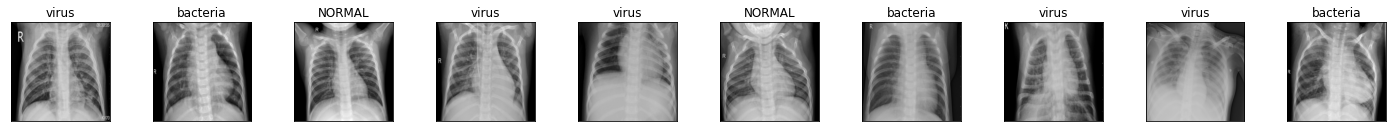

In [ ]:
#visualize some of the transformed images
images, labels = iter(alex_train_loader).next() # obtain one batch of images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(Multiclass_classes[labels[idx]])

In [ ]:
# RUN THIS CODE ONLY TO CREATE FEATURE TENSORS FROM RAW DATA - alexnet
# location on Google Drive
master_path = '/content/gdrive/My Drive/APS 360 Project/alex_features'

batch_size = 1 # save 1 file at a time, hence batch_size = 1
num_workers = 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
n=0
# save features to folder as tensors
for img, label in train_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = master_path +'/Train' + '/' + str(Multiclass_classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n +=1
for img, label in val_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = master_path +'/Val' + '/' + str(Multiclass_classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n+=1
for img, label in test_loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = master_path +'/Test' + '/' + str(Multiclass_classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n+=1

In [ ]:
# Load Tensor Files (features) from folder - alexnet
master_path = '/content/gdrive/My Drive/APS 360 Project/alex_features'
alex_trainset = torchvision.datasets.DatasetFolder(master_path+'/Train/', loader=torch.load, extensions=('.tensor'))
alex_valset = torchvision.datasets.DatasetFolder(master_path+'/Val/', loader=torch.load, extensions=('.tensor'))
alex_testset = torchvision.datasets.DatasetFolder(master_path+'/Test/', loader=torch.load, extensions=('.tensor'))

In [ ]:
# Prepare Dataloader -ALEX
batch_size = 32
num_workers = 1
torch.manual_seed(1) # set the random seed
tr_feature_loader = torch.utils.data.DataLoader(alex_trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_feature_loader = torch.utils.data.DataLoader(alex_valset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_feature_loader = torch.utils.data.DataLoader(alex_testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
# Verification Step - obtain one batch of features
dataiter = iter(tr_feature_loader)
tr_features, tr_labels = dataiter.next()
print(tr_features.shape)
print(tr_labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
#build model
class alex_CNN2(nn.Module):
    def __init__(self):
        super(alex_CNN2, self).__init__()
        self.name = "alex_CNN2"
        self.conv1 = nn.Conv2d(256,512,3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(512,1024,2)
        #add one more layeer
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 3) 
        #self.fc3 = nn.Linear(512, 3) #one of the 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        #print("4", x.shape)
        x = x.view(-1, 1024) #flatten feature data
        #print("5", x.shape)
        x = F.relu(self.fc1(x))
        #print("6", x.shape)
        x = F.relu(self.fc2(x))
        #print("7", x.shape)
        #x = F.relu(self.fc3(x))
        return x 

## 5. Training

### a) Sanity Check / Overfitting


#### Create overfit train loaders with 16 images

In [ ]:
#Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'
Normal_vs_Pneumonia_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Normal_vs_Pneumonia_dataset'
Bacteria_vs_Virus_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Bacteria_vs_Virus_dataset'
batch_size=16

t = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])
NP_data = torchvision.datasets.ImageFolder(root=Normal_vs_Pneumonia_dataset_Path, transform=t)
BV_data = torchvision.datasets.ImageFolder(root=Bacteria_vs_Virus_dataset_Path, transform=t)


NP_overfit_train_data, rest = torch.utils.data.random_split(NP_data, [batch_size, (len(NP_data)-batch_size)])
NP_overfit_train_loader = torch.utils.data.DataLoader(NP_overfit_train_data, batch_size=batch_size, shuffle=True)

BV_overfit_train_data, rest = torch.utils.data.random_split(BV_data, [batch_size, (len(BV_data)-batch_size)])
BV_overfit_train_loader = torch.utils.data.DataLoader(BV_overfit_train_data, batch_size=batch_size, shuffle=True)

#Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

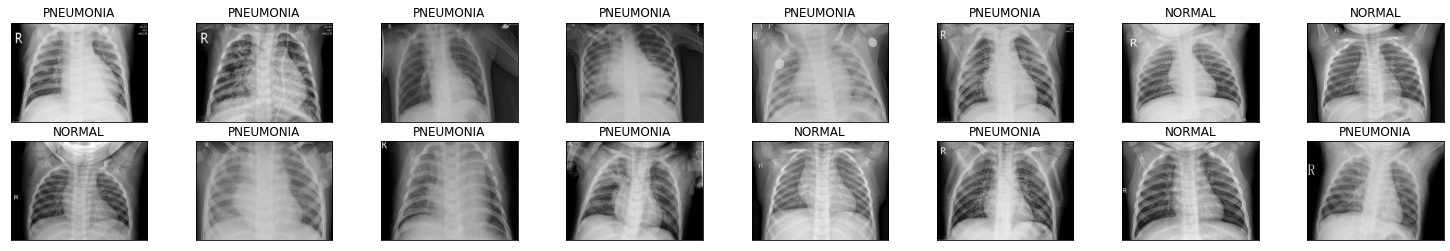

In [ ]:
# Verification on Multiclass dataset  
images, labels = iter(NP_overfit_train_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display

# plot 12 images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(26, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    ax.set_title(NP_classes[labels[idx]])

#### overfit training function

In [ ]:
def overfit(overfit_model, overfit_train_loader, val_loader, classes, learning_rate=0.001,  batch_size=16, num_epochs=60):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(overfit_model.parameters(), lr=learning_rate)
  iters, losses, train_acc, val_acc = [], [], [], []

  # training
  n = 0 # the number of iterations
  epochs, inv = [], []
  start_time=time.time()
  for epoch in range(num_epochs):
    for imgs, labels in iter(overfit_train_loader):

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      overfit_model.eval()   
      out = overfit_model(imgs)             # forward pass
      
      #print("out: ", out)
      #print("labels: ", labels)
      

      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

      # save the current training information
      iters.append(n)
      losses.append(float(loss)/batch_size)             # compute *average* loss
 
      n += 1

    epochs.append(epoch)
    if epoch % 30 == 0: 
      inv.append(epoch/30)
      train_acc.append(get_accuracy(overfit_model, overfit_train_loader))
      val_acc.append(get_accuracy(overfit_model, val_loader))
      print ("Iteration %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)), "Train Acc %f; Val Acc %f" % (
          train_acc[-1], val_acc[-1]))
    

  end_time= time.time()
  # plotting
  plt.title("Overfitting Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Overfitting Training Curve")
  plt.plot(inv, train_acc, label="Train")
  plt.plot(inv, val_acc, label="Validation")
  plt.xlabel("Iterations (*20)")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
#Convolutional Neural Network Architecture
#760 x 1050 image input

#Normal vs Pneumonia binary classifier
class NP_xray_CNN(nn.Module):
    def __init__(self):
        super(NP_xray_CNN, self).__init__()
        self.name = "NP_xray_CNN"
        self.conv1 = nn.Conv2d(1, 5, 30, stride=2) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 30, stride=2)
        self.fc1 = nn.Linear(38*56*10, 1000)
        self.fc2 = nn.Linear(1000, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 38*56*10)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

Normal vs Pneumonia overfit model
Iteration 0 Finished.  Time per Epoch:  33.47 s  Train Acc 0.687500; Val Acc 0.714123
Iteration 30 Finished.  Time per Epoch:   2.85 s  Train Acc 0.687500; Val Acc 0.714123
Iteration 60 Finished.  Time per Epoch:   2.34 s  Train Acc 0.687500; Val Acc 0.714123
Iteration 90 Finished.  Time per Epoch:   2.17 s  Train Acc 0.750000; Val Acc 0.735763
Iteration 120 Finished.  Time per Epoch:   2.09 s  Train Acc 1.000000; Val Acc 0.640091
Iteration 150 Finished.  Time per Epoch:   2.04 s  Train Acc 1.000000; Val Acc 0.617312
Iteration 180 Finished.  Time per Epoch:   2.00 s  Train Acc 1.000000; Val Acc 0.621868
Iteration 210 Finished.  Time per Epoch:   1.97 s  Train Acc 1.000000; Val Acc 0.627563
Iteration 240 Finished.  Time per Epoch:   1.95 s  Train Acc 1.000000; Val Acc 0.627563
Iteration 270 Finished.  Time per Epoch:   1.94 s  Train Acc 1.000000; Val Acc 0.625285


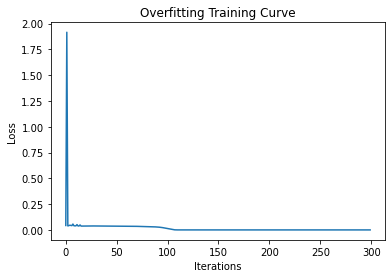

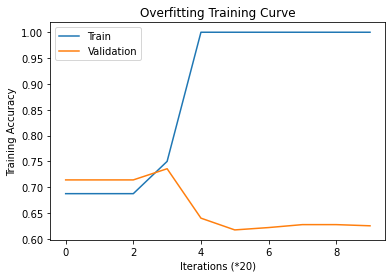

Final Training Accuracy: 1.0
Total time:   546.89 s  Time per Epoch:   1.82 s 



In [ ]:
overfit_NP_model = NP_xray_CNN()
overfit_BV_model = BV_xray_CNN()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  overfit_NP_model.cuda()
  overfit_BV_model.cuda()

print("Normal vs Pneumonia overfit model")
overfit(overfit_NP_model, NP_overfit_train_loader, NP_val_loader, NP_classes, learning_rate=0.001, batch_size=16, num_epochs=300)
print()
#print("Bacteria vs Virus overfit model")
#overfit(overfit_BV_model, BV_overfit_train_loader, BV_val_loader, BV_classes, learning_rate=0.001, batch_size=16, num_epochs=300)


Bacteria vs Virus overfit model
Iteration 0 Finished.  Time per Epoch:  222.11 s  Train Acc 0.750000; Val Acc 0.655608
Iteration 30 Finished.  Time per Epoch:   8.33 s  Train Acc 0.750000; Val Acc 0.655608
Iteration 60 Finished.  Time per Epoch:   4.82 s  Train Acc 1.000000; Val Acc 0.644550
Iteration 90 Finished.  Time per Epoch:   3.62 s  Train Acc 1.000000; Val Acc 0.671406
Iteration 120 Finished.  Time per Epoch:   3.02 s  Train Acc 1.000000; Val Acc 0.677725
Iteration 150 Finished.  Time per Epoch:   2.65 s  Train Acc 1.000000; Val Acc 0.677725
Iteration 180 Finished.  Time per Epoch:   2.41 s  Train Acc 1.000000; Val Acc 0.680885


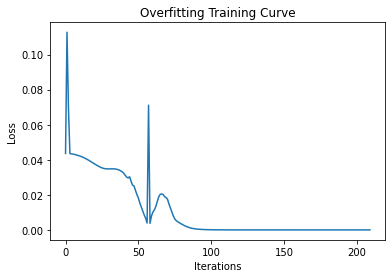

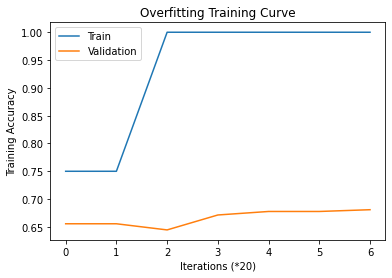

Final Training Accuracy: 1.0
Total time:   452.73 s  Time per Epoch:   2.16 s 


In [ ]:
print("Bacteria vs Virus overfit model")
overfit(overfit_BV_model, BV_overfit_train_loader, BV_val_loader, BV_classes, learning_rate=0.001, batch_size=16, num_epochs=210)

#####overfit for transfer learning model

In [ ]:
Multiclass_dataset_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/Multiclass_dataset'

bs = 32

Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
MC_overfit_train_data, rest = torch.utils.data.random_split(alex_trainset, [bs, (len(alex_trainset)-bs)])
MC_overfit_train_loader = torch.utils.data.DataLoader(MC_overfit_train_data, batch_size=bs, shuffle=True)


Normal vs Bacteria vs Virus overfit model
Iteration 0 Finished.  Time per Epoch:   1.33 s  Train Acc 0.437500; Val Acc 0.471264
Iteration 30 Finished.  Time per Epoch:   0.13 s  Train Acc 0.718750; Val Acc 0.674713
Iteration 60 Finished.  Time per Epoch:   0.11 s  Train Acc 1.000000; Val Acc 0.739080
Iteration 90 Finished.  Time per Epoch:   0.10 s  Train Acc 1.000000; Val Acc 0.743678
Iteration 120 Finished.  Time per Epoch:   0.10 s  Train Acc 1.000000; Val Acc 0.747126


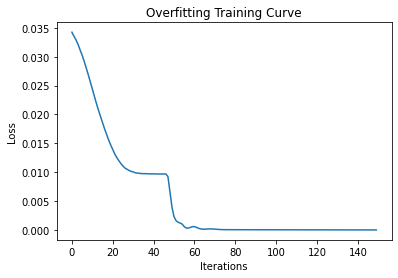

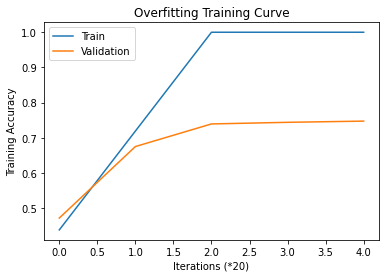

Final Training Accuracy: 1.0
Total time:   13.65 s  Time per Epoch:   0.09 s 



In [ ]:
#torch.manual_seed(10)
overfit_MC_model = alex_CNN2()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  overfit_MC_model.cuda()

print("Normal vs Bacteria vs Virus overfit model")
overfit(overfit_MC_model, MC_overfit_train_loader, val_feature_loader, Multiclass_classes, learning_rate=0.0001, batch_size=32, num_epochs=150)
print()

Normal vs Bacteria vs Virus overfit model
Iteration 0 Finished.  Time per Epoch:   1.43 s  Train Acc 0.500000; Val Acc 0.471264
Iteration 30 Finished.  Time per Epoch:   0.16 s  Train Acc 1.000000; Val Acc 0.728736
Iteration 60 Finished.  Time per Epoch:   0.14 s  Train Acc 1.000000; Val Acc 0.736782
Iteration 90 Finished.  Time per Epoch:   0.13 s  Train Acc 1.000000; Val Acc 0.736782
Iteration 120 Finished.  Time per Epoch:   0.13 s  Train Acc 1.000000; Val Acc 0.739080


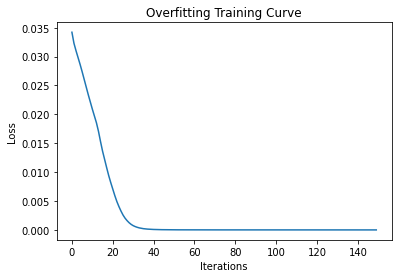

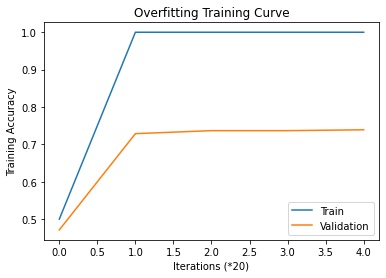

Final Training Accuracy: 1.0
Total time:   17.38 s  Time per Epoch:   0.12 s 



In [ ]:
#torch.manual_seed(10)
overfit_MC_model = alex_CNN2()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  overfit_MC_model.cuda()

print("Normal vs Bacteria vs Virus overfit model")
overfit(overfit_MC_model, MC_overfit_train_loader, val_feature_loader, Multiclass_classes, learning_rate=0.00005, batch_size=32, num_epochs=150)
print()

Thus our transfer learning model has the ability to overfit a small set of data

#### Overfit prediction visualization

In [ ]:
def overfit_visualization(overfit_model, overfit_train_loader, classes, catergory):
  corr = 0
  total = 0
  for imgs, labels in iter(overfit_train_loader):
    overfit_model.cpu()
    output = overfit_model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    corr += pred.eq(labels.view_as(pred)).sum().item()

    imgs = torch.squeeze(imgs)
    imgs = imgs.numpy() # convert images to numpy for display

    predict, correct = [], []
    for i in range(len(pred)):
      predict.append(classes[pred[i]])
      correct.append(classes[labels[i]])
    total += imgs.shape[0]
  test_accuracy = corr / total

  fig = plt.figure(figsize=(26, 4))
  for idx in np.arange(16):
      ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
      plt.imshow(imgs[idx], cmap='gray')
      plt.subplots_adjust(hspace=0.4)
      ax.set_title("Label:  " + classes[labels[idx]] + "\nPredicted:" + classes[pred[idx]])

  print("predicted label:", predict)
  print("correct label  :", correct)

  #print(correct, 'out of', total)
  if catergory == "NP_xray_CNN":
    print("The NP overfit model's training accuracy is:", test_accuracy)
  elif catergory == "BV_xray_CNN":
    print("The BV overfit model's training accuracy is:", test_accuracy)
  else:
    print("Unknown overfit model's training accuracy is:", test_accuracy)

predicted label: ['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA']
correct label  : ['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA']
The NP overfit model's training accuracy is: 1.0


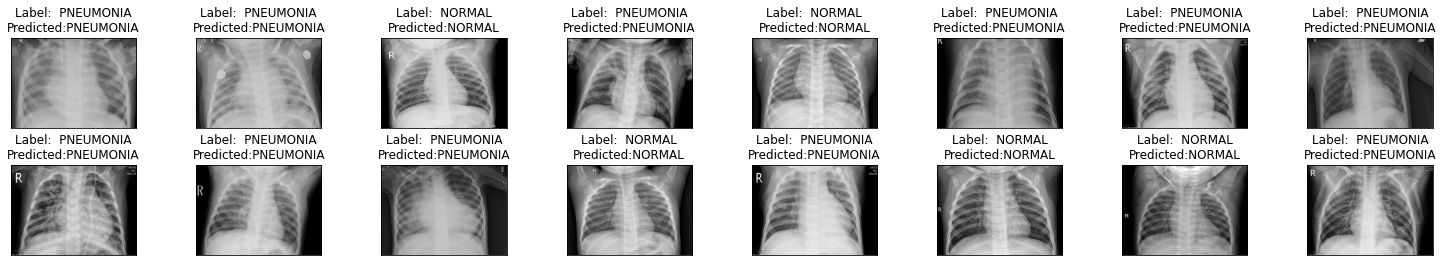

In [ ]:
overfit_visualization(overfit_NP_model, NP_overfit_train_loader, NP_classes, overfit_NP_model.name)

predicted label: ['bacteria', 'virus', 'bacteria', 'virus', 'bacteria', 'bacteria', 'virus', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'virus', 'bacteria', 'bacteria', 'bacteria']
correct label  : ['bacteria', 'virus', 'bacteria', 'virus', 'bacteria', 'bacteria', 'virus', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'bacteria', 'virus', 'bacteria', 'bacteria', 'bacteria']
The BV overfit model's training accuracy is: 1.0


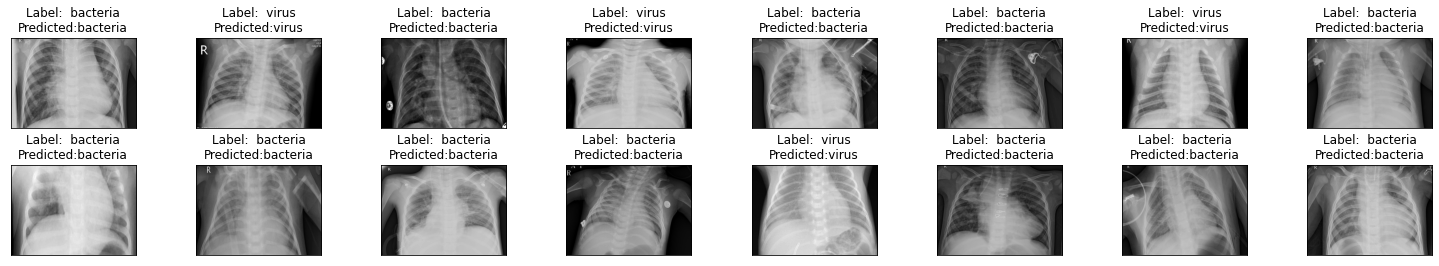

In [ ]:
overfit_visualization(overfit_BV_model, BV_overfit_train_loader, BV_classes, overfit_BV_model.name)

### b) Model Training

####Binary CNN Training

Normal vs Pneumonia Model
correct: 845 out of 879
The best NP model's test accuracy is: 0.9613196814562003


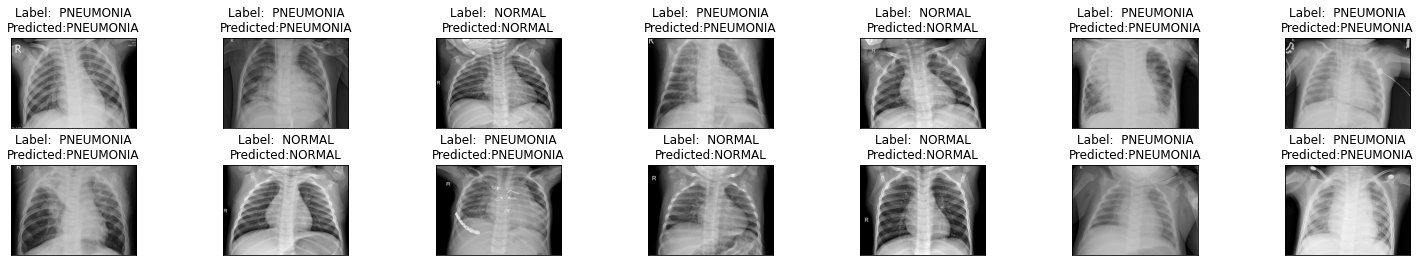

In [ ]:
NP_classes = ['NORMAL', 'PNEUMONIA']
test_visualization(best_NP_model, NP_test_loader, NP_classes, best_NP_model.name)

In [ ]:
def get_accuracy(model, loader):

  correct = 0
  total = 0

  model.eval()
  for imgs, labels in iter(loader):
    
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
  return correct / total

In [ ]:
def train(model, category, train_loader, val_loader, batch_size=32, num_epochs=5, learning_rate=0.001):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, losses, train_acc, val_acc = [], [], [], []
  initial = True

  # training
  n = 0 # number of iterations
  epochs = []
  start_time = time.time()

  for epoch in range(1, num_epochs+1):
    mini_b = 0
    #mini_batch_correct = 0
    #Mini_batch_total = 0
    for imgs, labels in iter(train_loader):

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      
      model.train()  
      out = model(imgs)             # forward pass

      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

      if initial:
        initial = False
        epochs.append(0)    
        train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Initial Iteration: Train Loss %f; Train Acc %f; Val Acc %f" % (
            float(loss), train_acc[-1], val_acc[-1]))
        
      ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole trainig set in every iteration!
      #pred = out.max(1, keepdim=True)[1]
      #mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
      #Mini_batch_total = imgs.shape[0]
      #train_acc.append((mini_batch_correct / Mini_batch_total))

      # save the current training information
      iters.append(n)
      losses.append(float(loss))             # compute *average* loss
      #train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
      #val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
      n += 1
      mini_b += 1
      #print("Iteration: ",n,'Progress: % 6.2f ' % (((epoch-1) * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%',
      #      "Time Elapsed: % 6.2f s " % (time.time()-start_time))
    
    epochs.append(epoch)    
    train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
    val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    print("Epoch %d: Train Loss %f; Train Acc %f; Val Acc %f" % (
          epoch, losses[-1], train_acc[-1], val_acc[-1]))
    print("Epoch %d Finished. " % (epoch) ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch)))

  end_time= time.time()
  print()
  # plotting
  if category == 'NP_xray_CNN':
    print("Normal vs Pneumonia Training Graphs:")
    print()
  elif category == 'BV_xray_CNN':
    print("Bacteria vs Virus Training Graphs:")
    print()
  else:
    print("Training Graphs:")
    print()

  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
  print()
  

Epoch 1: Train Loss 0.009501; Train Acc 0.738961; Val Acc 0.714123
Epoch 1 Finished.  Time per Epoch:  2307.95 s 
Epoch 2: Train Loss 0.005627; Train Acc 0.778483; Val Acc 0.779043
Epoch 2 Finished.  Time per Epoch:  1345.11 s 
Epoch 3: Train Loss 0.006396; Train Acc 0.827519; Val Acc 0.821185
Epoch 3 Finished.  Time per Epoch:  1020.76 s 
Epoch 4: Train Loss 0.004679; Train Acc 0.875091; Val Acc 0.881549
Epoch 4 Finished.  Time per Epoch:  857.33 s 
Epoch 5: Train Loss 0.015785; Train Acc 0.923640; Val Acc 0.920273
Epoch 5 Finished.  Time per Epoch:  759.14 s 

Normal vs Pneumonia Training Graphs:



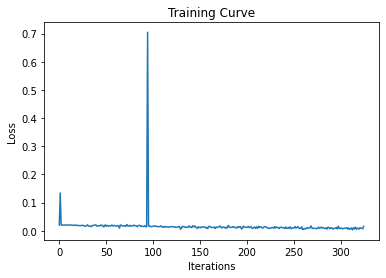

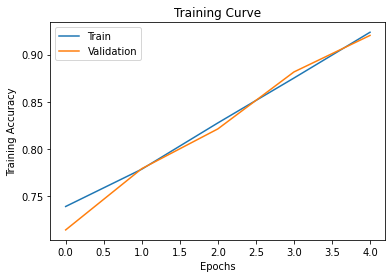

Final Training Accuracy: 0.9236399121737009
Final Validation Accuracy: 0.9202733485193622
Total time:   3795.71 s  Time per Epoch:  759.14 s 



In [ ]:
NP_model = NP_xray_CNN()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()

train(NP_model, NP_model.name, NP_train_loader, NP_val_loader)
# always save the file with different names to avoid overwritten
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 32, 0.001, 5, "Winston")
torch.save(NP_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.717170; Train Acc 0.738961; Val Acc 0.714123
Epoch 1: Train Loss 0.340494; Train Acc 0.738961; Val Acc 0.714123
Epoch 1 Finished.  Time per Epoch:  578.62 s 
Epoch 2: Train Loss 0.649260; Train Acc 0.737985; Val Acc 0.715262
Epoch 2 Finished.  Time per Epoch:  474.79 s 
Epoch 3: Train Loss 0.281886; Train Acc 0.836545; Val Acc 0.832574
Epoch 3 Finished.  Time per Epoch:  440.19 s 
Epoch 4: Train Loss 0.948618; Train Acc 0.868992; Val Acc 0.861048
Epoch 4 Finished.  Time per Epoch:  422.79 s 
Epoch 5: Train Loss 0.210950; Train Acc 0.887534; Val Acc 0.884966
Epoch 5 Finished.  Time per Epoch:  411.79 s 

Normal vs Pneumonia Training Graphs:



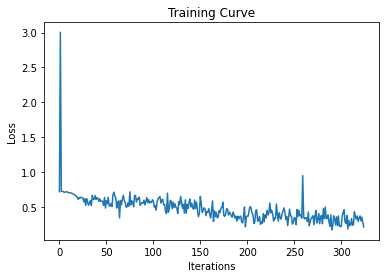

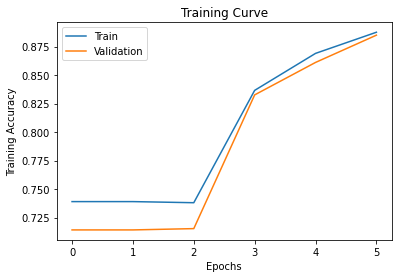

Final Training Accuracy: 0.8875335447670163
Final Validation Accuracy: 0.8849658314350797
Total time:   2058.95 s  Time per Epoch:  411.79 s 



In [ ]:
NP_model = NP_xray_CNN()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()

train(NP_model, NP_model.name, NP_train_loader, NP_val_loader)
# always save the file with different names to avoid overwritten
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 32, 0.001, 5, "Winston")
torch.save(NP_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.713529; Train Acc 0.639472; Val Acc 0.655608
Epoch 1: Train Loss 0.543310; Train Acc 0.640149; Val Acc 0.654028
Epoch 1 Finished.  Time per Epoch:  356.68 s 
Epoch 2: Train Loss 0.673302; Train Acc 0.708869; Val Acc 0.688784
Epoch 2 Finished.  Time per Epoch:  292.97 s 
Epoch 3: Train Loss 0.595826; Train Acc 0.721395; Val Acc 0.723539
Epoch 3 Finished.  Time per Epoch:  271.10 s 
Epoch 4: Train Loss 0.671065; Train Acc 0.726134; Val Acc 0.726698
Epoch 4 Finished.  Time per Epoch:  259.60 s 
Epoch 5: Train Loss 0.578580; Train Acc 0.744753; Val Acc 0.734597
Epoch 5 Finished.  Time per Epoch:  252.51 s 

Bacteria vs Virus Training Graphs:



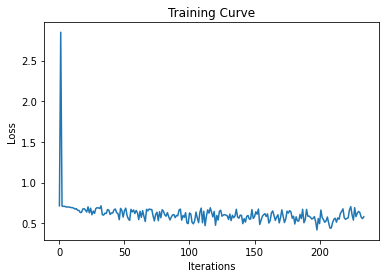

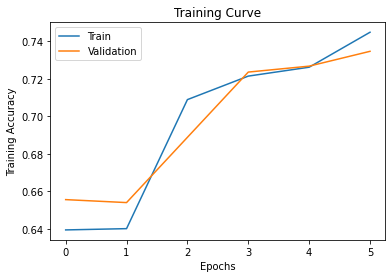

Final Training Accuracy: 0.7447528774542993
Final Validation Accuracy: 0.7345971563981043
Total time:   1262.53 s  Time per Epoch:  252.51 s 



In [ ]:
BV_model = BV_xray_CNN()

if use_cuda and torch.cuda.is_available():
  BV_model.cuda()

train(BV_model, BV_model.name, BV_train_loader, BV_val_loader)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 32, 0.001, 6, "Winston")
torch.save(BV_model.state_dict(), file_name)

####Transfer Learning Model Training

In [ ]:
def alex_eval(model, loader):

  correct = 0
  total = 0

  for fts, labels in iter(loader):
    
    if use_cuda and torch.cuda.is_available():
      fts = fts.cuda()
      labels = labels.cuda()

    output = model(fts)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += fts.shape[0]
  return correct / total

In [ ]:
def alex_train(model, category, tr_feature_loader, val_feature_loader, batch_size=32, num_epochs=5, learning_rate=0.001):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, losses, train_acc, val_acc = [], [], [], []
  initial = True

  # training
  n = 0 # number of iterations
  epochs = []
  start_time = time.time()

  for epoch in range(1, num_epochs+1):
    mini_b = 0
    #mini_batch_correct = 0
    #Mini_batch_total = 0
    for fts, labels in iter(tr_feature_loader):
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        fts = fts.cuda()
        labels = labels.cuda()

      out = model(fts)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch
      
      if initial:
        initial = False
        epochs.append(0)    
        train_acc.append(alex_eval(model, tr_feature_loader))  # compute training accuracy
        print("initial iter1")
        val_acc.append(alex_eval(model, val_feature_loader))  # compute validation accuracy
        print("Initial Iteration: Train Loss %f; Train Acc %f; Val Acc %f" % (
            float(loss), train_acc[-1], val_acc[-1]))

      # save the current training information
      iters.append(n)
      losses.append(float(loss))             # compute *average* loss
    
      n += 1
      mini_b += 1
      
    epochs.append(epoch)    
    train_acc.append(alex_eval(model, tr_feature_loader))  # compute training accuracy
    val_acc.append(alex_eval(model, val_feature_loader))  # compute validation accuracy
    print("Epoch %d: Train Loss %f; Train Acc %f; Val Acc %f" % (
          epoch, losses[-1], train_acc[-1], val_acc[-1]))
    print("Epoch %d Finished. " % (epoch) ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch)))

  end_time= time.time()
  # plotting

  print("Multi-class Training Graphs:")
   
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))
  print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
  print()
  

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
use_cuda = True

MC_model = googlenet_CNN()

if use_cuda and torch.cuda.is_available():
  MC_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')
alex_train(MC_model, MC_model.name, tr_feature_loader, val_feature_loader)

initial iter1
Initial Iteration: Train Loss 1.097124; Train Acc 0.274249; Val Acc 0.278161
Epoch 1: Train Loss 0.596887; Train Acc 0.692024; Val Acc 0.688506
Epoch 1 Finished.  Time per Epoch:  20.95 s 
Epoch 2: Train Loss 0.491743; Train Acc 0.703840; Val Acc 0.706897
Epoch 2 Finished.  Time per Epoch:  16.82 s 
Epoch 3: Train Loss 0.488930; Train Acc 0.853767; Val Acc 0.831034
Epoch 3 Finished.  Time per Epoch:  15.50 s 
Epoch 4: Train Loss 0.374489; Train Acc 0.877400; Val Acc 0.826437
Epoch 4 Finished.  Time per Epoch:  14.76 s 
Epoch 5: Train Loss 0.568757; Train Acc 0.849089; Val Acc 0.791954
Epoch 5 Finished.  Time per Epoch:  14.32 s 
Multi-class Training Graphs:


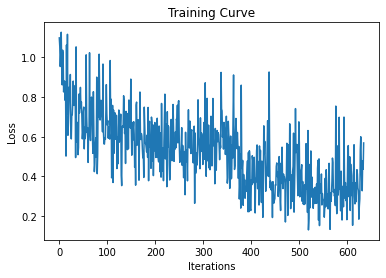

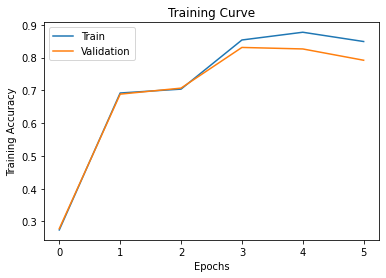

Final Training Accuracy: 0.8490891186607582
Final Validation Accuracy: 0.7919540229885057
Total time:   71.60 s  Time per Epoch:  14.32 s 



In [ ]:
use_cuda = True

MC_model = alex_CNN2()

if use_cuda and torch.cuda.is_available():
  MC_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')
alex_train(MC_model, MC_model.name, tr_feature_loader, val_feature_loader)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(MC_model.name, 32, 0.001, 6, "Erica")
torch.save(MC_model.state_dict(), file_name)


## 6. Hyperparameters Tuning

### a) Hyperparameters tuning for two CNN models

In [ ]:
bs=64

BV_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_train_loader.pth'.format(bs))
BV_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_val_loader.pth'.format(bs))
NP_train_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_train_loader.pth'.format(bs))
NP_val_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_val_loader.pth'.format(bs))


In [ ]:
use_cuda = True
NP_model = NP_xray_CNN()
BV_model = BV_xray_CNN()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
  BV_model.cuda()
  print('CUDA is available! Training on GPU ...')
  !nvidia-smi
else:
  print('CUDA is not available. Training on CPU ...')

CUDA is available! Training on GPU ...
Mon Jul 27 17:01:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    73W / 149W |    318MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                 

In [ ]:
def auto_train_hyper(model, train_loader, num_epochs, batch_size=16, learning_rate=0.0001):
    torch.manual_seed(24)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
          
          imgs, _ = data

          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()


          recon = model(imgs)
          
          loss = criterion(recon, imgs)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, imgs, recon),)
    return outputs

In [ ]:
outputs = auto_train_hyper(autoencoder, BV_train_loader, num_epochs=5)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format("autoencoder_hyper", 64, 0.008, 5, "Winston")
torch.save(autoencoder.state_dict(), file_name)

Initial Iteration: Train Loss 0.737685; Train Acc 0.269822; Val Acc 0.268793
Epoch 1: Train Loss 0.879804; Train Acc 0.797024; Val Acc 0.791572
Epoch 1 Finished.  Time per Epoch:  483.59 s 
Epoch 2: Train Loss 1.082532; Train Acc 0.856794; Val Acc 0.845103
Epoch 2 Finished.  Time per Epoch:  400.78 s 
Epoch 3: Train Loss 0.295594; Train Acc 0.860942; Val Acc 0.842825
Epoch 3 Finished.  Time per Epoch:  373.06 s 
Epoch 4: Train Loss 0.136911; Train Acc 0.886558; Val Acc 0.881549
Epoch 4 Finished.  Time per Epoch:  359.21 s 
Epoch 5: Train Loss 0.088159; Train Acc 0.917053; Val Acc 0.900911
Epoch 5 Finished.  Time per Epoch:  351.26 s 

Normal vs Pneumonia Training Graphs:



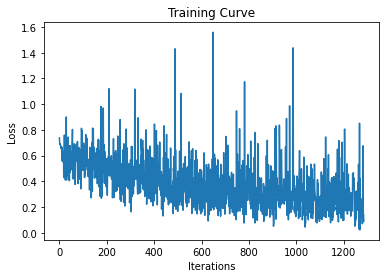

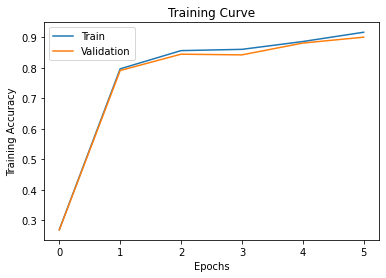

Final Training Accuracy: 0.9170529397414003
Final Validation Accuracy: 0.9009111617312073
Total time:   1756.30 s  Time per Epoch:  351.26 s 



In [ ]:
torch.manual_seed(10)
use_cuda = True

NP_model = NP_xray_CNN()


if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')

train(NP_model, NP_model.name, NP_train_loader, NP_val_loader, batch_size=16, num_epochs=5, learning_rate=0.001)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 16, 0.001, 5, "Crystal")
torch.save(NP_model.state_dict(), file_name)




Initial Iteration: Train Loss 0.653700; Train Acc 0.648612; Val Acc 0.619273
Epoch 1: Train Loss 0.589081; Train Acc 0.676710; Val Acc 0.676145
Epoch 1 Finished.  Time per Epoch:  305.81 s 
Epoch 2: Train Loss 0.434427; Train Acc 0.733243; Val Acc 0.723539
Epoch 2 Finished.  Time per Epoch:  253.38 s 
Epoch 3: Train Loss 0.457789; Train Acc 0.752200; Val Acc 0.742496
Epoch 3 Finished.  Time per Epoch:  236.87 s 
Epoch 4: Train Loss 0.703150; Train Acc 0.754232; Val Acc 0.737757
Epoch 4 Finished.  Time per Epoch:  228.46 s 
Epoch 5: Train Loss 0.658120; Train Acc 0.761002; Val Acc 0.748815
Epoch 5 Finished.  Time per Epoch:  223.11 s 

Bacteria vs Virus Training Graphs:



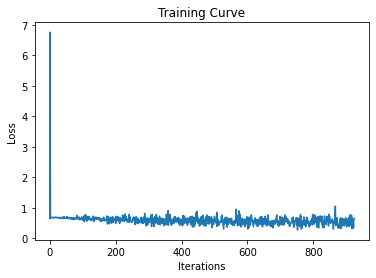

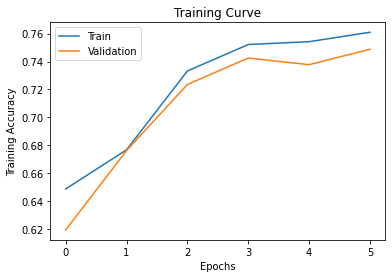

Final Training Accuracy: 0.7610020311442113
Final Validation Accuracy: 0.7488151658767772
Total time:   1115.56 s  Time per Epoch:  223.11 s 



In [ ]:
torch.manual_seed(10)
use_cuda = True

BV_model = BV_xray_CNN()
if use_cuda and torch.cuda.is_available():
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')


train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 16)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 16, 0.001, 5, "Crystal")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.737685; Train Acc 0.269822; Val Acc 0.268793
Epoch 1: Train Loss 0.883766; Train Acc 0.781654; Val Acc 0.779043
Epoch 1 Finished.  Time per Epoch:  512.42 s 
Epoch 2: Train Loss 0.910150; Train Acc 0.832642; Val Acc 0.829157
Epoch 2 Finished.  Time per Epoch:  424.93 s 
Epoch 3: Train Loss 0.307913; Train Acc 0.849719; Val Acc 0.839408
Epoch 3 Finished.  Time per Epoch:  395.68 s 
Epoch 4: Train Loss 0.162502; Train Acc 0.854599; Val Acc 0.850797
Epoch 4 Finished.  Time per Epoch:  380.61 s 
Epoch 5: Train Loss 0.213049; Train Acc 0.926811; Val Acc 0.917995
Epoch 5 Finished.  Time per Epoch:  371.45 s 

Normal vs Pneumonia Training Graphs:



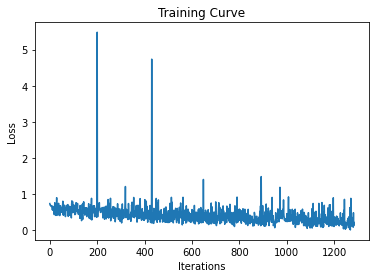

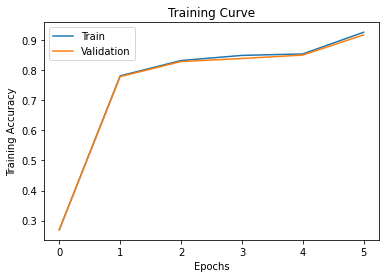

Final Training Accuracy: 0.9268114174188826
Final Validation Accuracy: 0.9179954441913439
Total time:   1857.26 s  Time per Epoch:  371.45 s 



In [ ]:
torch.manual_seed(10)
use_cuda = True

NP_model = NP_xray_CNN()


if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')

train(NP_model, NP_model.name, NP_train_loader, NP_val_loader, batch_size = 32)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 32, 0.001, 5, "Crystal")
torch.save(NP_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.680038; Train Acc 0.648612; Val Acc 0.619273
Epoch 1: Train Loss 0.605645; Train Acc 0.682126; Val Acc 0.674566
Epoch 1 Finished.  Time per Epoch:  434.09 s 
Epoch 2: Train Loss 0.496784; Train Acc 0.716994; Val Acc 0.712480
Epoch 2 Finished.  Time per Epoch:  362.98 s 
Epoch 3: Train Loss 0.478553; Train Acc 0.734259; Val Acc 0.720379
Epoch 3 Finished.  Time per Epoch:  338.48 s 
Epoch 4: Train Loss 0.661488; Train Acc 0.751523; Val Acc 0.729858
Epoch 4 Finished.  Time per Epoch:  326.85 s 
Epoch 5: Train Loss 0.447782; Train Acc 0.757955; Val Acc 0.740916
Epoch 5 Finished.  Time per Epoch:  320.26 s 
Epoch 6: Train Loss 0.674922; Train Acc 0.759648; Val Acc 0.734597
Epoch 6 Finished.  Time per Epoch:  315.98 s 
Epoch 7: Train Loss 0.618156; Train Acc 0.756263; Val Acc 0.715640
Epoch 7 Finished.  Time per Epoch:  312.96 s 
Epoch 8: Train Loss 0.526097; Train Acc 0.770142; Val Acc 0.740916
Epoch 8 Finished.  Time per Epoch:  310.60 s 
Epoch 9: Train Loss

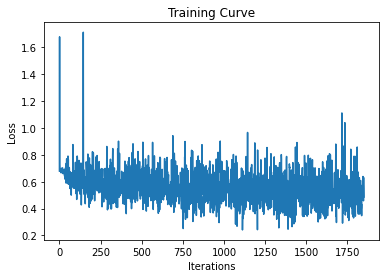

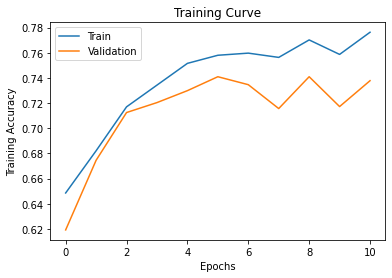

Final Training Accuracy: 0.7762356127285037
Final Validation Accuracy: 0.7377567140600316
Total time:   3071.74 s  Time per Epoch:  307.17 s 



In [ ]:
torch.manual_seed(10)
use_cuda = True

BV_model = BV_xray_CNN()
if use_cuda and torch.cuda.is_available():
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')


train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 32, num_epochs=10, learning_rate=0.001)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 32, 0.001, 10, "Crystal")
torch.save(BV_model.state_dict(), file_name)

In [ ]:
# Bacteria vs Virus binary classifier
class BV_xray_CNN_1(nn.Module):
    def __init__(self):
        super(BV_xray_CNN_1, self).__init__()
        self.name = "BV_xray_CNN_1"
        self.conv1 = nn.Conv2d(1, 6, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(6, 12, 50, stride=3)
        self.fc1 = nn.Linear(11*20*12, 500)
        self.fc2 = nn.Linear(500, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*12)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

Initial Iteration: Train Loss 0.690432; Train Acc 0.639472; Val Acc 0.655608
Epoch 1: Train Loss 0.726283; Train Acc 0.639472; Val Acc 0.655608
Epoch 1 Finished.  Time per Epoch:  1464.01 s 
Epoch 2: Train Loss 0.553736; Train Acc 0.665200; Val Acc 0.671406
Epoch 2 Finished.  Time per Epoch:  888.55 s 
Epoch 3: Train Loss 0.588150; Train Acc 0.672647; Val Acc 0.682464
Epoch 3 Finished.  Time per Epoch:  697.02 s 
Epoch 4: Train Loss 0.595751; Train Acc 0.730196; Val Acc 0.739336
Epoch 4 Finished.  Time per Epoch:  601.11 s 
Epoch 5: Train Loss 0.693482; Train Acc 0.733243; Val Acc 0.726698
Epoch 5 Finished.  Time per Epoch:  543.37 s 
Epoch 6: Train Loss 0.522323; Train Acc 0.731212; Val Acc 0.712480
Epoch 6 Finished.  Time per Epoch:  504.77 s 
Epoch 7: Train Loss 0.458462; Train Acc 0.732227; Val Acc 0.731438
Epoch 7 Finished.  Time per Epoch:  477.25 s 
Epoch 8: Train Loss 0.672577; Train Acc 0.750508; Val Acc 0.750395
Epoch 8 Finished.  Time per Epoch:  456.69 s 
Epoch 9: Train Los

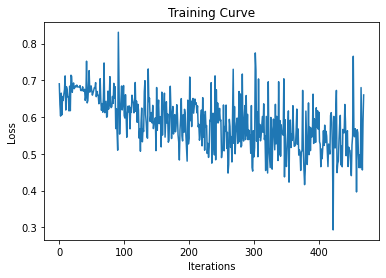

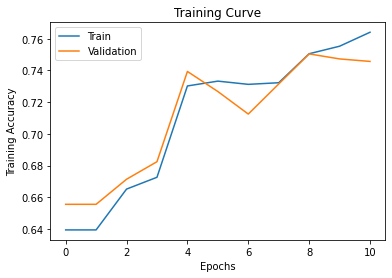

Final Training Accuracy: 0.7640487474610698
Final Validation Accuracy: 0.7456556082148499
Total time:   4274.33 s  Time per Epoch:  427.43 s 



In [ ]:

torch.manual_seed(10)
use_cuda = True

BV_model = BV_xray_CNN_1()
if use_cuda and torch.cuda.is_available():
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')


train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 32, num_epochs=10, learning_rate=0.0002)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 64, 0.0002, 10, "Winston")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.682700; Train Acc 0.639472; Val Acc 0.655608
Epoch 1: Train Loss 0.636742; Train Acc 0.639472; Val Acc 0.655608
Epoch 1 Finished.  Time per Epoch:  439.04 s 
Epoch 2: Train Loss 0.626597; Train Acc 0.639133; Val Acc 0.650869
Epoch 2 Finished.  Time per Epoch:  368.54 s 
Epoch 3: Train Loss 0.674452; Train Acc 0.699052; Val Acc 0.709321
Epoch 3 Finished.  Time per Epoch:  345.22 s 
Epoch 4: Train Loss 0.563951; Train Acc 0.705823; Val Acc 0.709321
Epoch 4 Finished.  Time per Epoch:  333.87 s 
Epoch 5: Train Loss 0.736082; Train Acc 0.725796; Val Acc 0.739336
Epoch 5 Finished.  Time per Epoch:  326.48 s 
Epoch 6: Train Loss 0.499076; Train Acc 0.734259; Val Acc 0.734597
Epoch 6 Finished.  Time per Epoch:  321.20 s 
Epoch 7: Train Loss 0.472578; Train Acc 0.757955; Val Acc 0.742496
Epoch 7 Finished.  Time per Epoch:  317.47 s 
Epoch 8: Train Loss 0.560249; Train Acc 0.769465; Val Acc 0.756714
Epoch 8 Finished.  Time per Epoch:  314.64 s 
Epoch 9: Train Loss

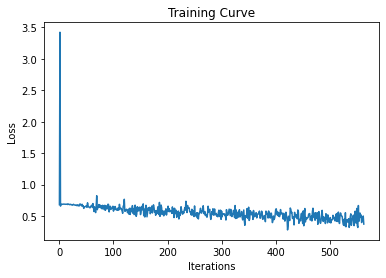

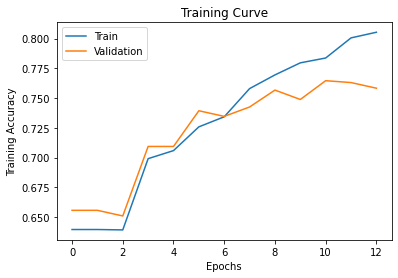

Final Training Accuracy: 0.8053486797562627
Final Validation Accuracy: 0.7582938388625592
Total time:   3693.06 s  Time per Epoch:  307.76 s 



In [ ]:

torch.manual_seed(10)
use_cuda = True

BV_model = BV_xray_CNN_1()
if use_cuda and torch.cuda.is_available():
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')


train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 64, num_epochs=12, learning_rate=0.0003)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 64, 0.0003, 12, "Winston")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.496904; Train Acc 0.812119; Val Acc 0.777251
Epoch 1: Train Loss 0.205242; Train Acc 0.825322; Val Acc 0.769352
Epoch 1 Finished.  Time per Epoch:  320.34 s 

Training Graphs:



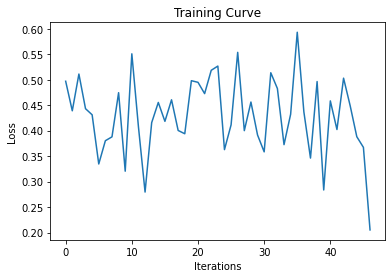

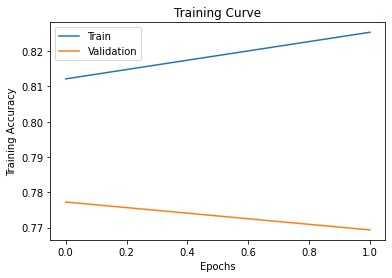

Final Training Accuracy: 0.8253215978334462
Final Validation Accuracy: 0.7693522906793049
Total time:   320.34 s  Time per Epoch:  320.34 s 



In [ ]:
# best BV 78%
BV_model_load = BV_xray_CNN_2()
BV_model_load.cuda()

BV_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_BV_xray_CNN_1_bs64_lr0.0003_epoch12_name_Winston"
BV_model_load.load_state_dict(torch.load(BV_file_name))

train(BV_model_load, BV_model_load.name, BV_train_loader, BV_val_loader, batch_size = 64, num_epochs=1, learning_rate=0.0003)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model_load.name, 64, 0.0003, 13, "Winston")
torch.save(BV_model_load.state_dict(), file_name)

In [ ]:
# Bacteria vs Virus binary classifier
class BV_xray_CNN_3(nn.Module):
    def __init__(self):
        super(BV_xray_CNN_3, self).__init__()
        self.name = "BV_xray_CNN_3"
        self.conv1 = nn.Conv2d(1, 10, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(10, 20, 50, stride=3)
        self.fc1 = nn.Linear(11*20*20, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)
        self.dropout5 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*20)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = F.relu(self.fc2(self.dropout4(x)))
        x = self.fc3(self.dropout5(x))
        return x

Initial Iteration: Train Loss 0.686790; Train Acc 0.639472; Val Acc 0.655608
Epoch 1: Train Loss 0.747805; Train Acc 0.639472; Val Acc 0.655608
Epoch 1 Finished.  Time per Epoch:  1411.97 s 
Epoch 2: Train Loss 0.648165; Train Acc 0.678064; Val Acc 0.698262
Epoch 2 Finished.  Time per Epoch:  818.34 s 
Epoch 3: Train Loss 0.625673; Train Acc 0.670278; Val Acc 0.652449
Epoch 3 Finished.  Time per Epoch:  620.57 s 
Epoch 4: Train Loss 0.490360; Train Acc 0.692620; Val Acc 0.699842
Epoch 4 Finished.  Time per Epoch:  521.80 s 
Epoch 5: Train Loss 0.629720; Train Acc 0.727488; Val Acc 0.723539
Epoch 5 Finished.  Time per Epoch:  462.37 s 
Epoch 6: Train Loss 0.553410; Train Acc 0.721733; Val Acc 0.723539
Epoch 6 Finished.  Time per Epoch:  422.99 s 
Epoch 7: Train Loss 0.393622; Train Acc 0.737305; Val Acc 0.721959
Epoch 7 Finished.  Time per Epoch:  394.69 s 
Epoch 8: Train Loss 0.561161; Train Acc 0.748138; Val Acc 0.733017
Epoch 8 Finished.  Time per Epoch:  374.45 s 
Epoch 9: Train Los

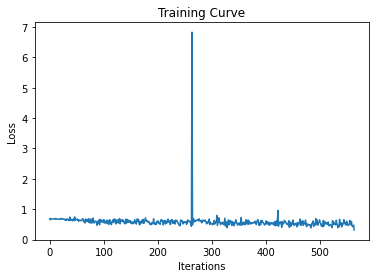

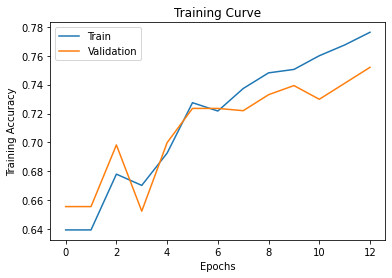

Final Training Accuracy: 0.7762356127285037
Final Validation Accuracy: 0.7519747235387045
Total time:   3905.79 s  Time per Epoch:  325.48 s 



In [ ]:

torch.manual_seed(10)
use_cuda = True

BV_model = BV_xray_CNN_3()
if use_cuda and torch.cuda.is_available():
  BV_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')


train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 64, num_epochs=12, learning_rate=0.0003)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 64, 0.0003, 12, "Winston")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.522507; Train Acc 0.775559; Val Acc 0.748815
Epoch 1: Train Loss 0.335299; Train Acc 0.781652; Val Acc 0.759874
Epoch 1 Finished.  Time per Epoch:  340.00 s 
Epoch 2: Train Loss 0.358878; Train Acc 0.791469; Val Acc 0.763033
Epoch 2 Finished.  Time per Epoch:  283.34 s 
Epoch 3: Train Loss 0.578049; Train Acc 0.799255; Val Acc 0.755134
Epoch 3 Finished.  Time per Epoch:  264.35 s 

Training Graphs:



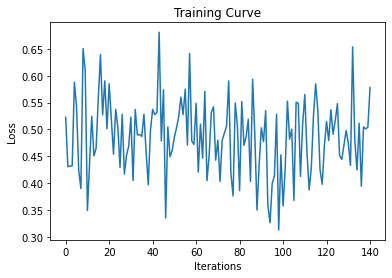

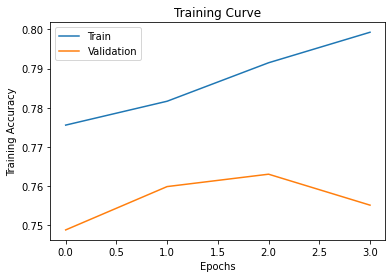

Final Training Accuracy: 0.7992552471225457
Final Validation Accuracy: 0.7551342812006319
Total time:   793.04 s  Time per Epoch:  264.35 s 



In [ ]:
# continue training from the previous cell
train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 64, num_epochs=3, learning_rate=0.0003)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 64, 0.0003, 15, "Winston")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.506236; Train Acc 0.791469; Val Acc 0.750395
Epoch 1: Train Loss 0.523086; Train Acc 0.803656; Val Acc 0.758294
Epoch 1 Finished.  Time per Epoch:  337.44 s 
Epoch 2: Train Loss 0.397939; Train Acc 0.810427; Val Acc 0.761453
Epoch 2 Finished.  Time per Epoch:  280.70 s 
Epoch 3: Train Loss 0.532437; Train Acc 0.821936; Val Acc 0.763033
Epoch 3 Finished.  Time per Epoch:  263.24 s 
Epoch 4: Train Loss 0.401864; Train Acc 0.833446; Val Acc 0.761453
Epoch 4 Finished.  Time per Epoch:  257.07 s 
Epoch 5: Train Loss 0.636143; Train Acc 0.842586; Val Acc 0.751975
Epoch 5 Finished.  Time per Epoch:  252.84 s 

Training Graphs:



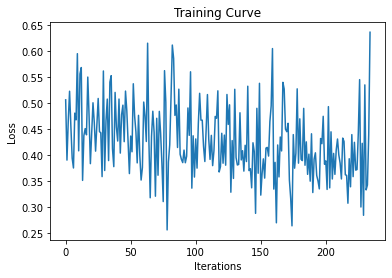

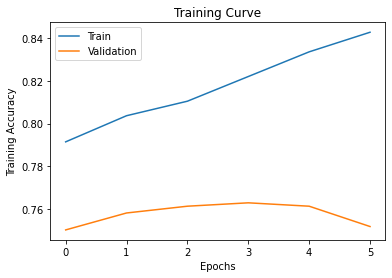

Final Training Accuracy: 0.8425863236289777
Final Validation Accuracy: 0.7519747235387045
Total time:   1264.22 s  Time per Epoch:  252.84 s 



In [ ]:
#continue training from the previous cell
train(BV_model, BV_model.name, BV_train_loader, BV_val_loader, batch_size = 64, num_epochs=5, learning_rate=0.0002)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(BV_model.name, 64, 0.0003, 20, "Winston")
torch.save(BV_model.state_dict(), file_name)

Initial Iteration: Train Loss 0.687967; Train Acc 0.738961; Val Acc 0.714123
Epoch 1: Train Loss 0.656097; Train Acc 0.738961; Val Acc 0.714123
Epoch 1 Finished.  Time per Epoch:  1853.32 s 
Epoch 2: Train Loss 0.237223; Train Acc 0.803611; Val Acc 0.797267
Epoch 2 Finished.  Time per Epoch:  1104.76 s 
Epoch 3: Train Loss 0.242587; Train Acc 0.840205; Val Acc 0.850797
Epoch 3 Finished.  Time per Epoch:  855.37 s 
Epoch 4: Train Loss 0.698712; Train Acc 0.911930; Val Acc 0.896355
Epoch 4 Finished.  Time per Epoch:  730.72 s 
Epoch 5: Train Loss 0.134605; Train Acc 0.938766; Val Acc 0.914579
Epoch 5 Finished.  Time per Epoch:  655.91 s 
Epoch 6: Train Loss 0.003092; Train Acc 0.921688; Val Acc 0.898633
Epoch 6 Finished.  Time per Epoch:  606.06 s 
Epoch 7: Train Loss 0.499588; Train Acc 0.942669; Val Acc 0.914579
Epoch 7 Finished.  Time per Epoch:  570.37 s 
Epoch 8: Train Loss 0.030381; Train Acc 0.971456; Val Acc 0.936219
Epoch 8 Finished.  Time per Epoch:  543.59 s 
Epoch 9: Train Lo

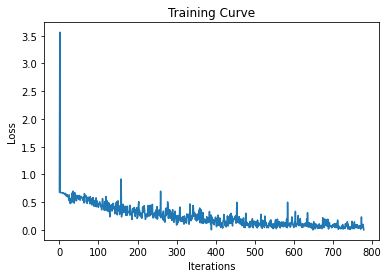

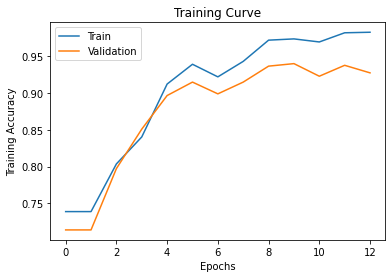

Final Training Accuracy: 0.9821907782385948
Final Validation Accuracy: 0.9271070615034168
Total time:   5770.48 s  Time per Epoch:  480.87 s 



In [ ]:
# NP best 94%
torch.manual_seed(10)
use_cuda = True

NP_model = NP_xray_CNN_1()

if use_cuda and torch.cuda.is_available():
  NP_model.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')

train(NP_model, NP_model.name, NP_train_loader, NP_val_loader, batch_size=64, num_epochs=12, learning_rate=0.0006)
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(NP_model.name, 64, 0.0006, 12, "Winston")
torch.save(NP_model.state_dict(), file_name)

In [ ]:
#report the testing accuracy of the best two models
correct = 0
total = 0
best_NP_model.eval()
best_BV_model.eval()
pred_NP, true_NP = [],[]
pred_BV, true_BV = [],[]

for imgs, labels in iter(NP_test_loader):
  
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()

  output = best_NP_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pred.numpy():
    pred_NP.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_NP.append(j[0])
  total += imgs.shape[0]
  pred_NP.append(pred.numpy())
  true_NP.append((labels.view_as(pred)).numpy())

NP_test_accuracy = correct / total
print("The test accuracy for Normal vs Pneumonia binary classifier is:", NP_test_accuracy)



correct = 0
total = 0
for imgs, labels in iter(BV_test_loader):
  
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()

  output = best_BV_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pred.numpy():
    pred_BV.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_BV.append(j[0]) 
  total += imgs.shape[0]
BV_test_accuracy = correct / total
print("The test accuracy for Bacteria vs Virus binary classifier is:", BV_test_accuracy)

### b) Hyperparameters tuning for transfer learning model

The first approach was to increase the batch size to 50 so that the model will be trained on more images. The other parameters remain the same.

We used a manual_seed = 10 for all the hyperparameters tuning below.

initial iter1
Initial Iteration: Train Loss 1.087512; Train Acc 0.479567; Val Acc 0.482759
Epoch 1: Train Loss 0.530616; Train Acc 0.832102; Val Acc 0.821839
Epoch 1 Finished.  Time per Epoch:  19.90 s 
Epoch 2: Train Loss 0.497688; Train Acc 0.827671; Val Acc 0.811494
Epoch 2 Finished.  Time per Epoch:  16.29 s 
Epoch 3: Train Loss 0.346693; Train Acc 0.857952; Val Acc 0.825287
Epoch 3 Finished.  Time per Epoch:  15.10 s 
Epoch 4: Train Loss 0.376883; Train Acc 0.892910; Val Acc 0.824138
Epoch 4 Finished.  Time per Epoch:  14.40 s 
Epoch 5: Train Loss 0.418414; Train Acc 0.886263; Val Acc 0.828736
Epoch 5 Finished.  Time per Epoch:  14.07 s 
Multi-class Training Graphs:


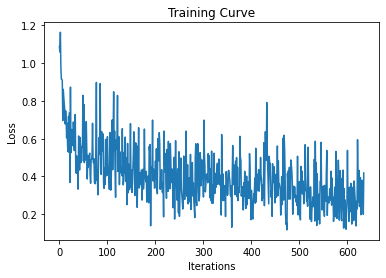

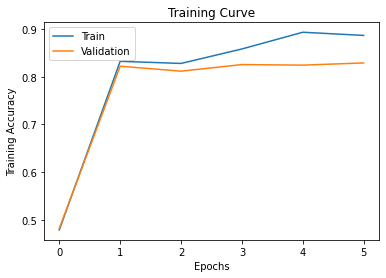

Final Training Accuracy: 0.8862629246676514
Final Validation Accuracy: 0.828735632183908
Total time:   70.34 s  Time per Epoch:  14.07 s 



In [ ]:
#first tuning attempt
torch.manual_seed(10)
use_cuda = True

test_transfer = alex_CNN2()

if use_cuda and torch.cuda.is_available():
  test_transfer.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')
alex_train(test_transfer, test_transfer.name, tr_feature_loader, val_feature_loader,batch_size = 50, num_epochs = 5,learning_rate = 0.001)


The model achieved a final validation accuray of 0.8287, which does not show a significant increase in accuracy from the training run. for the next training we changed the batch size back to 32, and decreased the learning rate to 0.00045.

initial iter1
Initial Iteration: Train Loss 1.082414; Train Acc 0.462334; Val Acc 0.471264
Epoch 1: Train Loss 0.378221; Train Acc 0.831118; Val Acc 0.816092
Epoch 1 Finished.  Time per Epoch:  1165.98 s 
Epoch 2: Train Loss 0.352754; Train Acc 0.833580; Val Acc 0.806897
Epoch 2 Finished.  Time per Epoch:  593.42 s 
Epoch 3: Train Loss 0.365119; Train Acc 0.869769; Val Acc 0.827586
Epoch 3 Finished.  Time per Epoch:  402.71 s 
Epoch 4: Train Loss 0.352739; Train Acc 0.901280; Val Acc 0.842529
Epoch 4 Finished.  Time per Epoch:  307.34 s 
Multi-class Training Graphs:


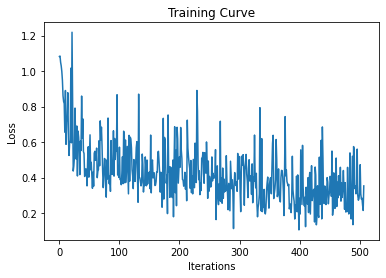

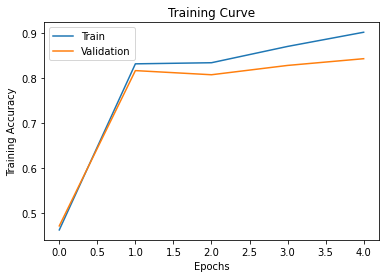

Final Training Accuracy: 0.9012801575578533
Final Validation Accuracy: 0.8425287356321839
Total time:   1229.34 s  Time per Epoch:  307.34 s 



In [ ]:
#second tuning attempt - best so far, with 2 conv alexCNN
torch.manual_seed(10)
use_cuda = True

test_transfer = alex_CNN2()

if use_cuda and torch.cuda.is_available():
  test_transfer.cuda()
else:
  print('CUDA is not available.  Training on CPU ...')
alex_train(test_transfer, test_transfer.name, tr_feature_loader, val_feature_loader,batch_size = 32, num_epochs = 4,learning_rate = 0.00045) #BEST SO FAR ,validation accuracy = 0.842 AT 4TH EPOCH

With those parameters the model achieved a final training accuracy of 0.90 and a validation accuracy of around 0.85.

In [ ]:
#save the best result to the drive
file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(test_transfer.name, 32, 0.00045, 4, "Joyce")
torch.save(test_transfer.state_dict(), file_name)

We will now compute the validation accuracy of our transfer learning model on **normal VS pneumonia** and **bacteria VS virus** imageset to compare with the 2 binary CNN model we built before to determine the best overall model.

In [ ]:
Multiclass_classes = ['NORMAL', 'bacteria', 'virus']

def alexnet_to_binary_accuracy(model, loader):

  NP_correct = 0
  NP_total = 0
  BV_correct = 0
  BV_total = 0

  correct = 0
  total = 0

  for fts, labels in iter(loader):
    
    if use_cuda and torch.cuda.is_available():
      fts = fts.cuda()
      labels = labels.cuda()

    output = model(fts)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]

    for i in range(len(pred)):
      normal_p = pred[i] == 0
      bacteria_p = pred[i] == 1
      virus_p = pred[i] == 2
      normal_l = labels[i] == 0
      bacteria_l = labels[i] == 1
      virus_l = labels[i] == 2

      if (normal_p and normal_l) or (bacteria_p and bacteria_l) or (virus_p and virus_l):
        NP_correct += 1
        NP_total += 1
        if (bacteria_p and bacteria_l) or (virus_p and virus_l):
          BV_correct += 1
          BV_total += 1
      else:
        if (normal_p ^ normal_l) and not (normal_p and normal_l):
          NP_total += 1
        elif (bacteria_p ^ bacteria_l) and not (bacteria_p and bacteria_l):
          NP_total += 1
          BV_total += 1
        elif (virus_p ^ virus_l) and not (virus_p and virus_l):
          NP_total += 1
          BV_total += 1

    #correct += pred.eq(labels.view_as(pred)).sum().item()
    #total += fts.shape[0]

  print("Normal vs Pneumonia")
  print('correct:', NP_correct, 'out of', NP_total)
  print("The NP validation accuracy is:", NP_correct/NP_total)
  print()
  print("Bacteria vs Virus")
  print('correct:', BV_correct, 'out of', BV_total)
  print("The BV validation accuracy is:", BV_correct/BV_total)

  #return correct / total

In [ ]:
#report the test accuracy of best multiclass model
use_cuda = True
best_MC_model = alex_CNN2()

file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(best_MC_model.name, 32, 0.00045, 4, "Joyce")
best_MC_model.load_state_dict(torch.load(file_name))

if use_cuda and torch.cuda.is_available():
  best_MC_model.cuda()
  print("Using GPU...")

alexnet_to_binary_accuracy(best_MC_model,val_feature_loader)

Using GPU...
Normal vs Pneumonia
correct: 733 out of 870
The NP validation accuracy is: 0.8425287356321839

Bacteria vs Virus
correct: 514 out of 623
The BV validation accuracy is: 0.8250401284109149


Even though the transfer learning model showed a higher validation accuracy on the Bacteria VS Virus imageset, its accuracy on Normal vs Pneumonia is lower than what we achieved with the CNN model (around 93% accuracy). Therefore the team would be using the CNN model as the final testing model. 

## 7. Evaluation

### a) Report the test accuracy of the best model

In [ ]:
#Step two: Load saved best Model test files
use_cuda = False
best_NP_model = NP_xray_CNN_1()
best_BV_model = BV_xray_CNN_2()

# load back the models with the best validation results
NP_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(best_NP_model.name, 64, 0.0006, 12, "Winston")
best_NP_model.load_state_dict(torch.load(NP_file_name))

BV_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(best_BV_model.name, 64, 0.0003, 13, "Winston")
best_BV_model.load_state_dict(torch.load(BV_file_name))

if use_cuda and torch.cuda.is_available():
  best_NP_model.cuda()
  best_BV_model.cuda()
  print("Using GPU...")

#Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

In [ ]:
#Step Three: Load saved test loader files
# Run this cell only to load all dataloaders

bs = 64 # select batch size
num_workers = 1

if not os.path.isdir('../content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}'.format(bs)):
  print("Cannot load. This batch size dataloader has not been created yet.")
else:
  NP_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/NP_test_loader.pth'.format(bs))
  BV_test_loader = torch.load('/content/gdrive/My Drive/APS 360 Project/dataloader_bs{0}/BV_test_loader.pth'.format(bs))

NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

In [ ]:
def test_visualization(model, test_loader, classes, catergory, dim = 14):
  corr = 0
  total = 0
  model.eval()
  for imgs, labels in iter(test_loader):
    #model.cpu()
    if use_cuda and torch.cuda.is_available():
      #model.cuda()
      imgs = imgs.cuda()
      labels = labels.cuda()
    
    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    corr += pred.eq(labels.view_as(pred)).sum().item()

    imgs = torch.squeeze(imgs)
    imgs = imgs.cpu().numpy() # convert images to numpy for display

    predict, correct = [], []
    for i in range(len(pred)):
      predict.append(classes[pred[i]])
      correct.append(classes[labels[i]])
    total += imgs.shape[0]
    
  test_accuracy = corr / total

  fig = plt.figure(figsize=(26, 4))
  for idx in np.arange(dim):
      if (dim%2) == 0:
        ax = fig.add_subplot(2, dim/2, idx+1, xticks=[], yticks=[])
      else:
        ax = fig.add_subplot(2, dim, idx+1, xticks=[], yticks=[])
      if dim > 1:
        plt.imshow(imgs[idx], cmap='gray')
      else:
        plt.imshow(imgs, cmap='gray')
      plt.subplots_adjust(hspace=0.4)
      ax.set_title("Label:  " + classes[labels[idx]] + "\nPredicted:" + classes[pred[idx]])

  #print("predicted label:", predict)
  #print("correct label  :", correct)

  
  if "NP_xray_CNN" in catergory:
    print("Normal vs Pneumonia Model")
    print('correct:', corr, 'out of', total)
    print("The best NP model's test accuracy is:", test_accuracy)
  elif "BV_xray_CNN" in catergory:
    print("Bacteria vs Virus Model")
    print('correct:', corr, 'out of', total)
    print("The best BV model's test accuracy is:", test_accuracy)
  else:
    print('correct:', corr, 'out of', total)
    print("Unknown model's test accuracy is:", test_accuracy)

In [ ]:
#Step four: report the testing accuracy of the best two models
correct = 0
total = 0
best_NP_model.eval()
best_BV_model.eval()
pred_NP, true_NP = [],[]
pred_BV, true_BV = [],[]

for imgs, labels in iter(NP_test_loader):
  
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()

  output = best_NP_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pred.numpy():
    pred_NP.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_NP.append(j[0])
  total += imgs.shape[0]

NP_test_accuracy = correct / total
print("The test accuracy for Normal vs Pneumonia binary classifier is:", NP_test_accuracy)


correct = 0
total = 0
for imgs, labels in iter(BV_test_loader):
  
  if use_cuda and torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()

  output = best_BV_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pred.numpy():
    pred_BV.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_BV.append(j[0]) 
  total += imgs.shape[0]
BV_test_accuracy = correct / total
print("The test accuracy for Bacteria vs Virus binary classifier is:", BV_test_accuracy)

The test accuracy for Normal vs Pneumonia binary classifier is: 0.9283276450511946
The test accuracy for Bacteria vs Virus binary classifier is: 0.7555205047318612


Normal vs Pneumonia Model
correct: 816 out of 879
The best NP model's test accuracy is: 0.9283276450511946


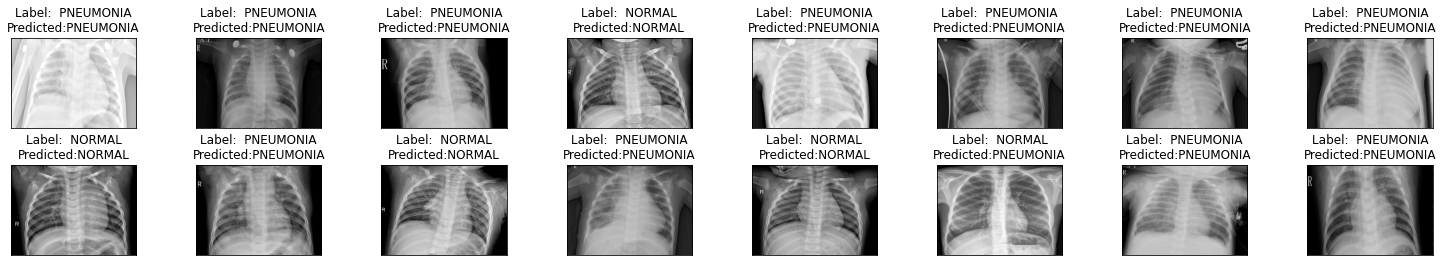

In [ ]:
#Plot sample images from test loader with both predicted and true labels
NP_classes = ['NORMAL', 'PNEUMONIA']
test_visualization(best_NP_model, NP_test_loader, NP_classes, best_NP_model.name)

Bacteria vs Virus Model
correct: 479 out of 634
The best BV model's test accuracy is: 0.7555205047318612


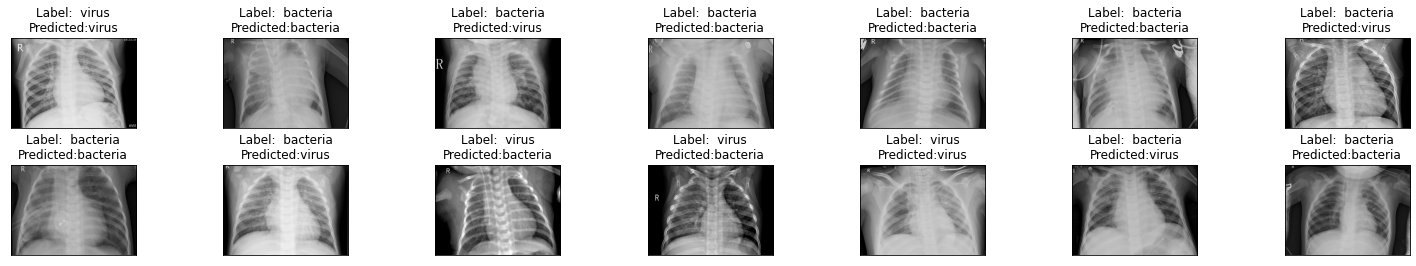

In [ ]:
BV_classes = ['bacteria', 'virus']
test_visualization(best_BV_model, BV_test_loader, BV_classes, best_BV_model.name)

### b) Confusion Matrix and ROC curve


In [ ]:
#Step 5: compute and visualize the confusion matrix on the best CNN models
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title ="Confusion matrix",
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title = "confusion matrix"
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true=np.asarray(true_NP), y_pred=np.asarray(pred_NP))
cm_plot_labels = NP_classes
fig, ax = plt.subplots()
ax.set_title("Normal VS Pneumonia Test Confusion Matrix")
plot_confusion_matrix(cm=cm, classes=NP_classes,normalize=False)

cm = confusion_matrix(y_true=true_BV, y_pred=pred_BV)
cm_plot_labels = BV_classes
fig, ax = plt.subplots()
ax.set_title("Bacterial VS Virus Pneumonia Test Confusion Matrix")
plot_confusion_matrix(cm=cm, classes=BV_classes,normalize=False)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def ROC_curve(y_true, y_pred, classes):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
                                 
    plt.figure(figsize=(7, 5))

    for i in range(len(classes)):
      plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    plt.plot(fpr[0], fpr[0], 'k-', label = 'random guessing')

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

    plt.tight_layout()

Confusion matrix, without normalization
[[222  40]
 [ 23 594]]
Confusion matrix, without normalization
[[353  71]
 [ 84 126]]


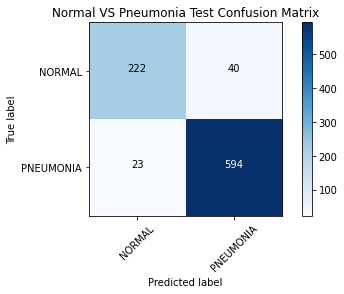

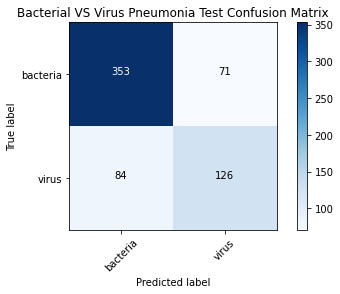

In [ ]:
#Plot confusion matrix 
cm = confusion_matrix(y_true=np.asarray(true_NP), y_pred=np.asarray(pred_NP))
cm_plot_labels = NP_classes
fig, ax = plt.subplots()
ax.set_title("Normal VS Pneumonia Test Confusion Matrix")
plot_confusion_matrix(cm=cm, classes=NP_classes,normalize=False)

cm = confusion_matrix(y_true=true_BV, y_pred=pred_BV)
cm_plot_labels = BV_classes
fig, ax = plt.subplots()
ax.set_title("Bacterial VS Virus Pneumonia Test Confusion Matrix")
plot_confusion_matrix(cm=cm, classes=BV_classes,normalize=False)

NP MODEL:
True Positive Rate = 0.967,
True Negative Rate = 0.841,
False Positive Rate = 0.153,
False Negative Rate = 0.037

 **Treating Pneumonia as positive*



BV MODEL:
True Positive Rate = 0.6,
True Negative Rate = 0.833,
False Positive Rate = 0.167,
False Negative Rate = 0.4


**Treating virus pneumonia as positive*


### c) Additional Testing

####Demo


In [ ]:
#Loading model structures
#Normal vs Pneumonia binary classifier - best model
class NP_xray_CNN_1(nn.Module):
    def __init__(self):
        super(NP_xray_CNN_1, self).__init__()
        self.name = "NP_xray_CNN_1"
        self.conv1 = nn.Conv2d(1, 10, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(10, 20, 50, stride=3)
        self.fc1 = nn.Linear(11*20*20, 600)
        self.fc2 = nn.Linear(600, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*20)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

# Bacteria vs Virus binary classifier - best model
class BV_xray_CNN_2(nn.Module):
    def __init__(self):
        super(BV_xray_CNN_2, self).__init__()
        self.name = "BV_xray_CNN_2"
        self.conv1 = nn.Conv2d(1, 8, 50, stride=3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(8, 15, 50, stride=3)
        self.fc1 = nn.Linear(11*20*15, 600)
        self.fc2 = nn.Linear(600, 2)
        self.dropout1 = nn.Dropout(0.2) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.dropout1(x))))
        x = self.pool(F.relu(self.conv2(self.dropout2(x))))
        x = x.view(-1, 11*20*15)
        x = F.relu(self.fc1(self.dropout3(x)))
        x = self.fc2(self.dropout4(x))
        return x

In [ ]:
#Function that prints out testing accuracy and randomly show 10 images with correct and predicted lables
def test_visualization(model, test_loader, classes, catergory, dim = 14):
  corr = 0
  total = 0
  model.eval()
  for imgs, labels in iter(test_loader):
    #model.cpu()
    if use_cuda and torch.cuda.is_available():
      #model.cuda()
      imgs = imgs.cuda()
      labels = labels.cuda()
    
    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    corr += pred.eq(labels.view_as(pred)).sum().item()

    imgs = torch.squeeze(imgs)
    imgs = imgs.cpu().numpy() # convert images to numpy for display

    predict, correct = [], []
    for i in range(len(pred)):
      predict.append(classes[pred[i]])
      correct.append(classes[labels[i]])
    total += imgs.shape[0]

  print(output.softmax(1))  
  test_accuracy = corr / total

  fig = plt.figure(figsize=(40, 10))
  for idx in np.arange(dim):
      if (dim%2) == 0:
        ax = fig.add_subplot(2, dim/2, idx+1, xticks=[], yticks=[])
      else:
        ax = fig.add_subplot(2, dim, idx+1, xticks=[], yticks=[])
      if dim > 1:
        plt.imshow(imgs[idx], cmap='gray')
      else:
        plt.imshow(imgs, cmap='gray')
      plt.subplots_adjust(hspace=0.4)
      ax.set_title("Label:  " + classes[labels[idx]] + "\nPredicted:" + classes[pred[idx]],fontsize = 30)

  #print("predicted label:", predict)
  #print("correct label  :", correct)

  
  if "NP_xray_CNN" in catergory:
    print("Normal vs Pneumonia Model")
    print('correct:', corr, 'out of', total)
    print("The best NP model's test accuracy is:", test_accuracy)
  elif "BV_xray_CNN" in catergory:
    print("Bacteria vs Virus Model")
    print('correct:', corr, 'out of', total)
    print("The best BV model's test accuracy is:", test_accuracy)
  else:
    print('correct:', corr, 'out of', total)
    print("Unknown model's test accuracy is:", test_accuracy)

In [ ]:
#Load saved best model path files
use_cuda = False
best_NP_model = NP_xray_CNN_1()
best_BV_model = BV_xray_CNN_2()

# load back the models with the best validation results
NP_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(best_NP_model.name, 64, 0.0006, 12, "Winston")
best_NP_model.load_state_dict(torch.load(NP_file_name))

BV_file_name = "/content/gdrive/My Drive/APS 360 Project/model_tuning/project_model_{0}_bs{1}_lr{2}_epoch{3}_name_{4}".format(best_BV_model.name, 64, 0.0003, 13, "Winston")
best_BV_model.load_state_dict(torch.load(BV_file_name))

if use_cuda and torch.cuda.is_available():
  best_NP_model.cuda()
  best_BV_model.cuda()
  print("Using GPU...")

#Multiclass_classes = ['NORMAL', 'bacteria', 'virus']
NP_classes = ['NORMAL', 'PNEUMONIA']
BV_classes = ['bacteria', 'virus']

In [ ]:
#Step 1: Loading four testing images to 2 dataloaders for 2 models 

Normal_vs_Pneumonia_test_Path = '/content/gdrive/My Drive/APS 360 Project/Testing_demo'
Bacteria_vs_Virus_test_Path = '/content/gdrive/My Drive/APS 360 Project/Testing_demo/PNEUMONIA'


t1 = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(root=Normal_vs_Pneumonia_test_Path, transform=t1)
NP_classes = ['NORMAL', 'PNEUMONIA']

NP_test_loader = torch.utils.data.DataLoader(data, batch_size=5, shuffle=True)
n = normal = pneumonia = 0
for img, labels in iter(NP_test_loader):
  for i in range(len(labels.numpy())):
    if labels.numpy()[i] == 0:
      normal += 1
    else:
      pneumonia += 1
    i += 1

print("For Normal_vs_Pneumonia binary classification: ")
print("labels:", data.class_to_idx)
print("test example number: ", len(NP_test_loader.dataset))
print("{0} normal images, {1} pneumonia images".format(normal,pneumonia))
print()


data = torchvision.datasets.ImageFolder(root=Bacteria_vs_Virus_test_Path, transform=t1)
BV_classes = ['bacteria', 'virus']

BV_test_loader = torch.utils.data.DataLoader(data, batch_size=4, shuffle=True)
n = bac = virus = 0
for img, labels in iter(BV_test_loader):
  for i in range(len(labels.numpy())):
    if labels.numpy()[i] == 0:
      bac += 1
    else:
      virus += 1
    n += 1
  


For Normal_vs_Pneumonia binary classification: 
labels: {'NORMAL': 0, 'PNEUMONIA': 1}
test example number:  5
1 normal images, 4 pneumonia images



In [ ]:
#Step 3: Image visualization - NP
images, labels = iter(NP_test_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy()
fig = plt.figure(figsize=(100, 30))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    plt.subplots_adjust(hspace=0.4)
    ax.set_title(NP_classes[labels[idx]],fontsize = 70)

Output hidden; open in https://colab.research.google.com to view.

tensor([[8.6470e-01, 1.3530e-01],
        [8.7590e-02, 9.1241e-01],
        [7.9272e-08, 1.0000e+00],
        [1.1901e-02, 9.8810e-01],
        [3.2605e-05, 9.9997e-01]], grad_fn=<SoftmaxBackward>)
Normal vs Pneumonia Model
correct: 5 out of 5
The best NP model's test accuracy is: 1.0


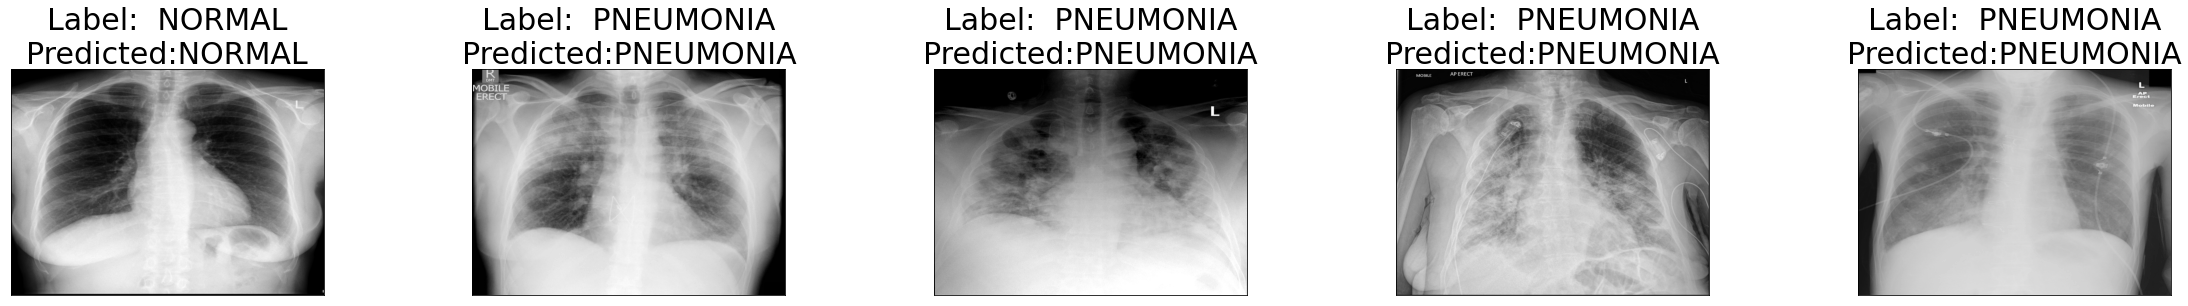

In [ ]:
#step 4: testing and visualization - NP
test_visualization(best_NP_model,NP_test_loader,NP_classes,best_NP_model.name, dim = 5)

For Bacteria_vs_Virus binary classification: 
labels: {'bacteria': 0, 'virus': 1}
test example number:  4
1 bacteria pneumonia images, 3 virus pneumonia images



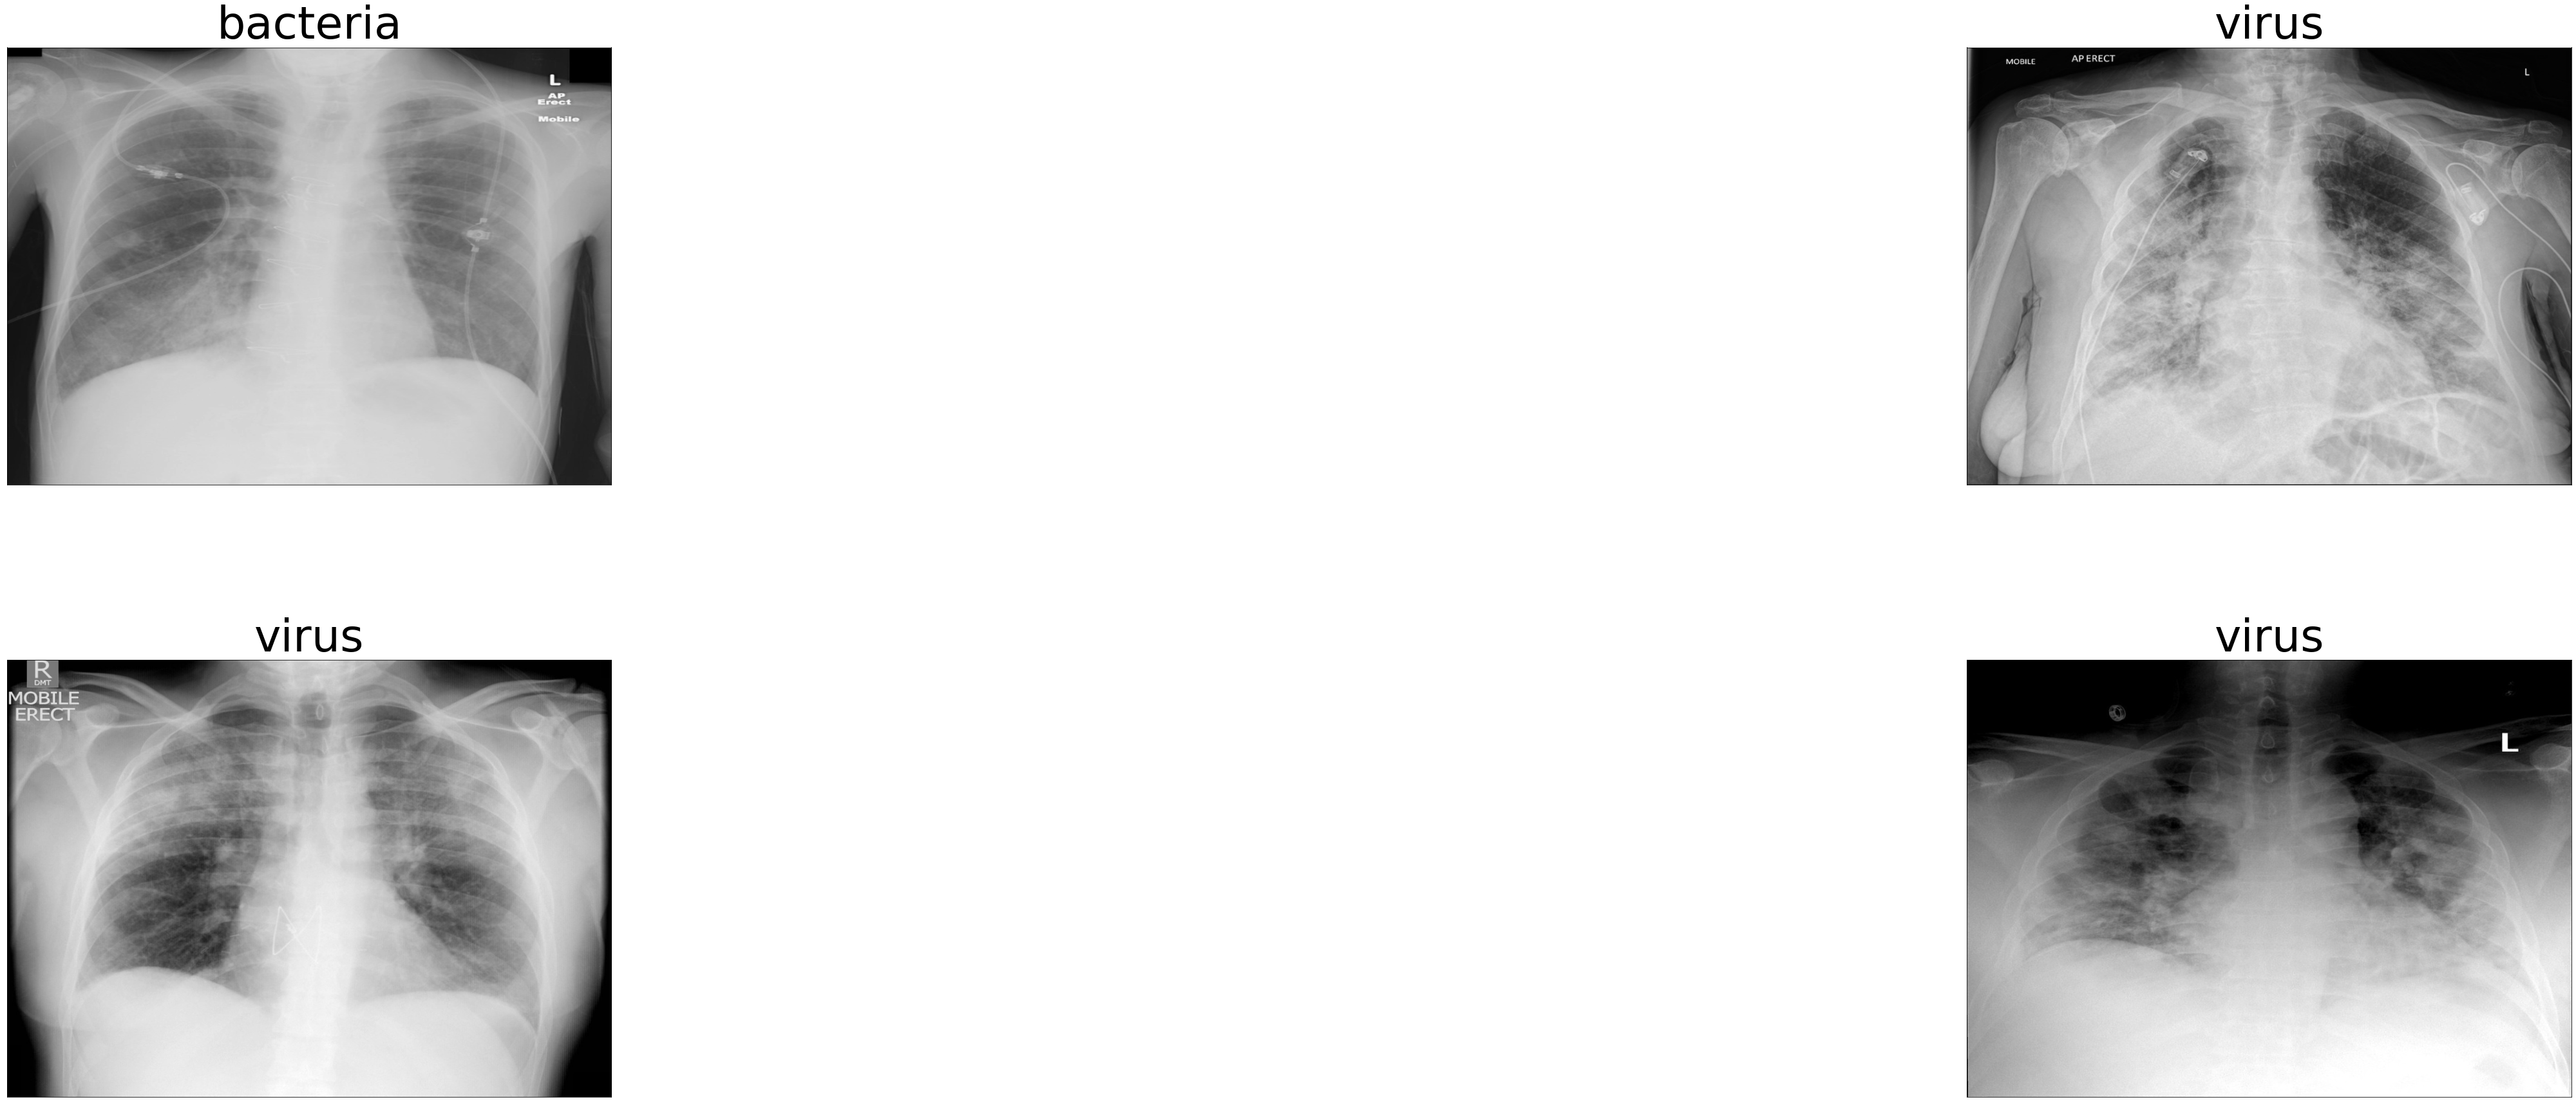

In [ ]:
#Step 5: Image visulization - BV
print("For Bacteria_vs_Virus binary classification: ")
print("labels:", data.class_to_idx)
print("test example number: ", len(BV_test_loader.dataset))
print("{0} bacteria pneumonia images, {1} virus pneumonia images".format(bac,virus))
print()

images, labels = iter(BV_test_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy()
fig = plt.figure(figsize=(100, 30))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx], cmap='gray')
    plt.subplots_adjust(hspace=0.4)
    ax.set_title(BV_classes[labels[idx]],fontsize = 70)

tensor([[0.3883, 0.6117],
        [0.8913, 0.1087],
        [0.2507, 0.7493],
        [0.8066, 0.1934]], grad_fn=<SoftmaxBackward>)
Bacteria vs Virus Model
correct: 3 out of 4
The best BV model's test accuracy is: 0.75


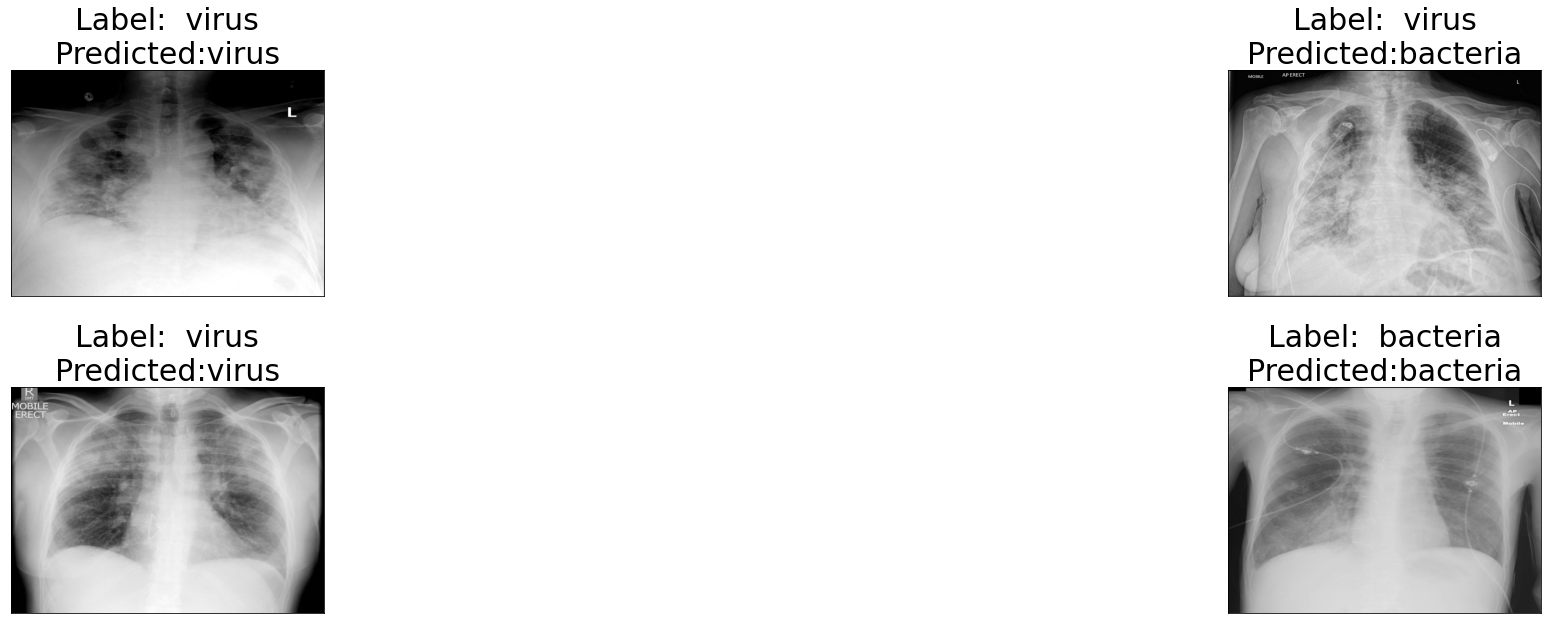

In [ ]:
#step 6: testing and visualization - BV
test_visualization(best_BV_model,BV_test_loader,BV_classes,best_BV_model.name, dim = 4)

####Testing
The team obatined addtional chest X-ray images from Radiopaedia (an open platform for radiology reference) as the additional dataset for testing



For Normal_vs_Pneumonia binary classification: 
labels: {'NORMAL': 0, 'PNEUMONIA': 1}
test example number:  23
8 normal images, 15 pneumonia images

For Bacteria_vs_Virus binary classification: 
labels: {'bacteria': 0, 'virus': 1}
test example number:  15
8 bacteria pneumonia images, 7 virus pneumonia images



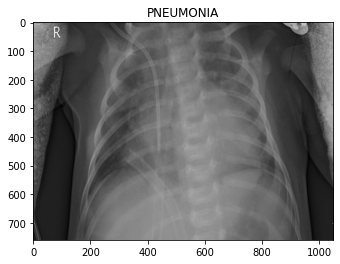

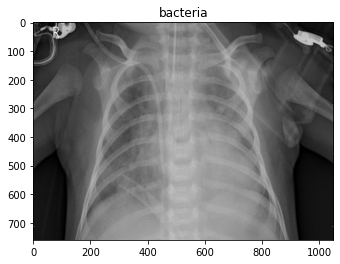

In [ ]:
#Loading additional testing data for CNN testing

Normal_vs_Pneumonia_test_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/N_vs_P_add'
Bacteria_vs_Virus_test_Path = '/content/gdrive/My Drive/APS 360 Project/dataset/B_vs_V_add'


t1 = transforms.Compose(
        [transforms.Resize((760, 1050)),
         transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(root=Normal_vs_Pneumonia_test_Path, transform=t1)
NP_classes = ['NORMAL', 'PNEUMONIA']

NP_test_loader = torch.utils.data.DataLoader(data, batch_size=25, shuffle=True)
n = normal = pneumonia = 0
for img, labels in iter(NP_test_loader):
  for i in range(len(labels.numpy())):
    if labels.numpy()[n] == 0:
      normal += 1
    else:
      pneumonia += 1
    n += 1

print("For Normal_vs_Pneumonia binary classification: ")
print("labels:", data.class_to_idx)
print("test example number: ", len(NP_test_loader.dataset))
print("{0} normal images, {1} pneumonia images".format(normal,pneumonia))
print()


data = torchvision.datasets.ImageFolder(root=Bacteria_vs_Virus_test_Path, transform=t1)
BV_classes = ['bacteria', 'virus']

BV_test_loader = torch.utils.data.DataLoader(data, batch_size=15, shuffle=True)
n = bac = virus = 0
for img, labels in iter(BV_test_loader):
  for i in range(len(labels.numpy())):
    if labels.numpy()[n] == 0:
      bac += 1
    else:
      virus += 1
    n += 1
  
print("For Bacteria_vs_Virus binary classification: ")
print("labels:", data.class_to_idx)
print("test example number: ", len(BV_test_loader.dataset))
print("{0} bacteria pneumonia images, {1} virus pneumonia images".format(bac,virus))
print()


# Verification 
images, labels = iter(NP_test_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display
fig, ax = plt.subplots()
ax.set_title(NP_classes[labels[0]])
plt.imshow(images[0], cmap='gray')
plt.show()

# Verification  
images, labels = iter(BV_test_loader).next() # obtain one batch of images
images = torch.squeeze(images)
images = images.numpy() # convert images to numpy for display
fig, ax = plt.subplots()
ax.set_title(BV_classes[labels[0]])
plt.imshow(images[0], cmap='gray')
plt.show()

In [ ]:
#report the test accuracy of best CNN model on the addtional testset 
use_cuda = False
pred_NP, true_NP = [],[]
pred_BV, true_BV = [],[]
correct = 0
total = 0
best_NP_model.eval()
for imgs, labels in iter(NP_test_loader):

  output = best_NP_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pr.numpy():
    pred_NP.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_NP.append(j[0])
  total += imgs.shape[0]

test_accuracy = correct / total
print("The test accuracy for normal vs pneumonia classifier on additional test data is: ", test_accuracy )

#report the test accuracy of best CNN model on the addtional testset 
correct = 0
total = 0
best_BV_model.eval()


for imgs, labels in iter(BV_test_loader):

  output = best_BV_model(imgs)
  
  #select index with maximum prediction score
  pred = output.max(1, keepdim=True)[1]
  correct += pred.eq(labels.view_as(pred)).sum().item()
  for i in pred.numpy():
    pred_BV.append(i[0])
  for j in labels.view_as(pred).numpy():
    true_BV.append(j[0])
  total += imgs.shape[0]

test_accuracy = correct / total
print("The test accuracy for bacterial vs virus pneumonia classifier on additional test data is: ", test_accuracy)

The test accuracy for normal vs pneumonia classifier on additional test data is: 0.8695652173913043
The test accuracy for bacterial vs virus pneumonia classifier on additional test data is: 0.8066666666666667


Confusion matrix, without normalization
[[ 8  0]
 [ 3 12]]
Confusion matrix, without normalization
[[8 0]
 [2 5]]


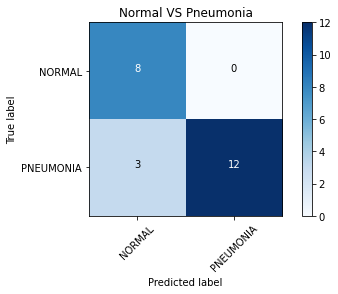

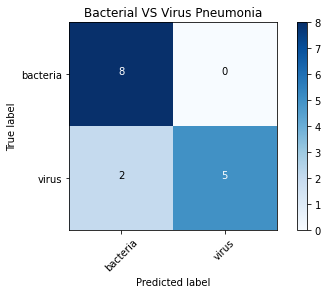

In [ ]:
#confusion matrix for additional testing
cm = confusion_matrix(y_true=true_NP, y_pred=pred_NP)
cm_plot_labels = NP_classes
fig, ax = plt.subplots()
ax.set_title("Normal VS Pneumonia")
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,normalize=False)

cm = confusion_matrix(y_true=true_BV, y_pred=pred_BV)
cm_plot_labels = BV_classes
fig, ax = plt.subplots()
ax.set_title("Bacterial VS Virus Pneumonia")
plot_confusion_matrix(cm=cm, classes=BV_classes,normalize=False)